In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.api.types import is_numeric_dtype

In [2]:
!pip install tensorflow

  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl (22.9 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached tensorflow_io_gcs_filesystem-0.33.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached Werkzeug-2.2.3-py3-none-any.whl (233 kB)


In [3]:
import tensorflow as tf

2023-08-21 23:47:29.294721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 23:47:30.832584: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-21 23:47:30.832783: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [4]:
!pip install keras

In [5]:
!pip install scikeras

  Using cached scikeras-0.10.0-py3-none-any.whl (27 kB)


In [6]:
import keras
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [7]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [8]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

  Using cached livelossplot-0.5.5-py3-none-any.whl (22 kB)
  Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)


In [9]:
!pip install shap
import shap

  Using cached shap-0.42.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (545 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [10]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [11]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [12]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [13]:
data_analysis_folder_path = '../'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [14]:
project_id = "master-thesis-2023-393813" # Fill project id
bqclient = bigquery.Client(project_id)

## Loading data

In [15]:
dataset_name = "twitbot_22_preprocessed_common_users_ids" #"twitbot_22_preprocessed"
users_table_name = "users"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
table_id = project_id + "." + BQ_TABLE_USERS

In [16]:
job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=True
)

In [17]:
# SQL_QUERY = f"""SELECT * FROM {BQ_TABLE_USERS} LIMIT 10000"""
# users_df1 = bqclient.query(SQL_QUERY).to_dataframe()

In [ ]:
SQL_QUERY = f"""WITH 
  human_records AS (
    SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'human' 
    LIMIT 5000),
  bot_records AS (
  SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'bot' 
    LIMIT 5000)
  SELECT * FROM human_records 
    UNION ALL SELECT * 
    FROM bot_records 
    ORDER BY row_num;"""

users_df1 = bqclient.query(SQL_QUERY).to_dataframe()
users_df1 = users_df1.drop(['row_num'], axis=1)

In [18]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [19]:
num_bots = len(users_df1.loc[users_df1['label']=='bot'])       # bots number
num_humans = len(users_df1.loc[users_df1['label']=='human'])   # humans number

print("Number of real users: ", num_humans)
print("Number of bots: ", num_bots)

Number of real users:  7867
Number of bots:  2133


In [20]:
org_users_df = pd.DataFrame(users_df1).copy()
users_df2 = pd.DataFrame(org_users_df).copy()

#### Filter to have same number of record for each class - part I (second part after data analysis and reducing some of outliers)

In [21]:
def filter_df_for_balanced_classes(df, bot_label_value='bot', human_label_value='human'):
    new_df = pd.DataFrame()

    i = 0 # bots iter.
    j = 0 # humans iter.
    k = 0
    num_bots = len(df.loc[df['label']==bot_label_value])
    num_humans = len(df.loc[df['label']==human_label_value])
    max_num = min(num_bots, num_humans)
    for index, record in df.iterrows():
      if k < (2*max_num):
        if record['label']==bot_label_value and i < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          i += 1
          k += 1
        if record['label']==human_label_value and j < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          j += 1
          k += 1
            
    print("Number of bots: ", len(new_df.loc[new_df['label']==bot_label_value]))
    print("Number of human users: ", len(new_df.loc[new_df['label']==human_label_value]))
    
    return pd.DataFrame(new_df).copy();

In [22]:
users_df = filter_df_for_balanced_classes(users_df2)

Number of bots:  2133
Number of human users:  2133


## Data preparation

In [23]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

In [24]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

#### Align values for bool columns

In [25]:
boolean_columns = ["verified", "protected", "withheld", "has_location", "has_profile_image_url", "has_pinned_tweet", "has_description"]

In [26]:
# Firstly align boolean columns values
for col_name in boolean_columns:
    users_df[col_name] = users_df[col_name].astype(bool)

column_to_remove = []
# Check unique values (some of subset can have only one unique value for some feature) if so it column will be removed from dataframe
for col_name in boolean_columns:
    uniq_val_list = users_df[col_name].unique()
    print("Column {:<24} {}".format(col_name, str(uniq_val_list)))
    if (len(uniq_val_list) < 2):
        column_to_remove.append(col_name)

Column verified                 [False  True]
Column protected                [False  True]
Column withheld                 [False]
Column has_location             [ True False]
Column has_profile_image_url    [ True False]
Column has_pinned_tweet         [False  True]
Column has_description          [ True False]


In [27]:
column_to_remove

['withheld']

In [28]:
# remove from bool columns:
for col_name in column_to_remove:
    boolean_columns.remove(col_name)
# remove from dataframe
users_df = drop_columns(users_df, column_to_remove)

### Encoding of non-numeric information which will be used by model

In [29]:
# Remap the values of the dataframe
for col_name in boolean_columns:
  users_df[col_name] = users_df[col_name].map({True:1,False:0})

# Remap label values human/bot for 0/1
label_col = "label"
users_df[label_col] = users_df[label_col].map({"human":0,"bot":1})


In [30]:
users_df

id  label         username                    name  \
0     1484544053572419585      0  blessing_xettry        #Blessing xettry   
1     1447956502443069446      0      menametaken               winwinnie   
2     1487790036322033674      0    VShipExpress1          V Ship Express   
3      901531094507507715      0        dbamiloye  Damilola Mike-Bamiloye   
4     1329634133379665921      0  Languagegamesny        Languagegamesnyc   
...                   ...    ...              ...                     ...   
9977  1214029823984599040      1  againstempiric1                magee ��   
9978  1480060548410580995      1  MetawarOfficial                 Metawar   
9979  1338724314766585856      1    steinartgroup         stein art group   
9987   782641505089363968      1    kessentiniglp     Marouane Kessentini   
9988           1708464528      1       JSociology    Journal of Sociology   

        created_at  verified  protected  has_location    location  \
0     1.642778e+09         0          0             1       Nepal   
1     1.634055e+09         0          0             1  your walls   
2     1.643552e+09         0          0             1      Canada   
3     1.503777e+09         0          0             1     Nigeria   
4     1.605844e+09         0          0             1    New York   
...            ...       ...        ...           ...         ...   
9977  1.578282e+09         0          0             0        None   
9978  1.641709e+09         0          0             0        None   
9979  1.608012e+09         0          0             0        None   
9987  1.475431e+09         0          0             0        None   
9988  1.377732e+09         0          0             0        None   

      has_profile_image_url  has_pinned_tweet                      url  \
0                         1                 0                            
1                         1                 0                            
2                         1                 0  https://t.co/HE80bmcMvk   
3                         1                 1                            
4                         1                 1  https://t.co/jN9HYPLgeV   
...                     ...               ...                      ...   
9977                      1                 0                            
9978                      1                 1                            
9979                      1                 0  https://t.co/WbtX3bST1a   
9987                      1                 0                            
9988                      1                 0   http://t.co/QbiSibtEmi   

      followers_count  following_count  tweet_count  listed_count  \
0                 0.0             24.0          1.0           0.0   
1                 0.0             20.0          1.0           0.0   
2                 0.0              0.0         26.0           0.0   
3             54528.0            190.0       5039.0          11.0   
4                 1.0            128.0         79.0           0.0   
...               ...              ...          ...           ...   
9977            172.0             81.0       2245.0           5.0   
9978         283820.0              2.0          7.0          54.0   
9979            174.0           1555.0         34.0           0.0   
9987            183.0            187.0        159.0           0.0   
9988           4791.0            515.0       1242.0         109.0   

      has_description  \
0                   1   
1                   1   
2                   1   
3                   1   
4                   1   
...               ...   
9977                1   
9978                1   
9979                1   
9987                0   
9988                1   

                                                                                                                                         description  \
0                                                                           Okay, well, maybe not 

#### Null and NaN statistics

In [31]:
for col_name in users_df:
    count1 = pd.isnull(users_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
label: 0
username: 0
name: 0
created_at: 0
verified: 0
protected: 0
has_location: 0
location: 1413
has_profile_image_url: 0
has_pinned_tweet: 0
url: 0
followers_count: 0
following_count: 0
tweet_count: 0
listed_count: 0
has_description: 0
description: 0
descr_no_hashtags: 0
descr_no_cashtags: 0
descr_no_mentions: 0
descr_no_urls: 0
url_no_urls: 0


#### Extract some information from dataframe to new columns

##### Description length

In [32]:
users_df['descr_len'] = users_df['description'].apply(len).astype(float)

##### Account age (in days) (sice 16.03.2022) (dataset data collected during the 20/01-15/03/2022 period)

In [33]:
from datetime import datetime

In [34]:
def cal_days_diff(a,b):
    A = a.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    B = b.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    return (A - B).days

def convert_unixtime_to_datetime(a):
    return datetime.utcfromtimestamp(a)

In [35]:
base_date = datetime(2022, 3, 16)
users_df['account_age'] = users_df.apply(lambda x: cal_days_diff(base_date, convert_unixtime_to_datetime(x.created_at)), axis=1).astype(float)

#### Reduce unnecessary columns

In [36]:
# users_reduced_df = pd.DataFrame(users_df).copy()
# # columns_to_drop = ["id", "username", "name", "created_at", "location", "url", "description"]
# columns_to_drop = ["username", "name", "created_at", "location", "url", "description"]
# users_reduced_df = drop_columns(users_reduced_df, columns_to_drop)
# users_reduced_df

### Filter data, left column by feature importance based on SHAP results

In [37]:
shap_features = ['followers_count', 'tweet_count', 'following_count', 'account_age', 'descr_len']

In [38]:
users_reduced_df = users_df.copy()
users_reduced_df = users_df.filter(['label', 'id']+shap_features)
users_reduced_df

label                   id  followers_count  tweet_count  \
0         0  1484544053572419585              0.0          1.0   
1         0  1447956502443069446              0.0          1.0   
2         0  1487790036322033674              0.0         26.0   
3         0   901531094507507715          54528.0       5039.0   
4         0  1329634133379665921              1.0         79.0   
...     ...                  ...              ...          ...   
9977      1  1214029823984599040            172.0       2245.0   
9978      1  1480060548410580995         283820.0          7.0   
9979      1  1338724314766585856            174.0         34.0   
9987      1   782641505089363968            183.0        159.0   
9988      1           1708464528           4791.0       1242.0   

      following_count  account_age  descr_len  
0                24.0         54.0       72.0  
1                20.0        155.0       85.0  
2                 0.0         45.0      138.0  
3               190.0       1663.0       90.0  
4               128.0        481.0       80.0  
...               ...          ...        ...  
9977             81.0        800.0       78.0  
9978              2.0         66.0       72.0  
9979           1555.0        456.0       86.0  
9987            187.0       1991.0        0.0  
9988            515.0       3122.0      141.0  

[4266 rows x 7 columns]

### Data type conversion (to float)

In [39]:
for (column_name, column_data) in users_reduced_df.iteritems():
    users_reduced_df[column_name] = users_reduced_df[column_name].astype(float)

### Data split for training, validation and testing

In [40]:
train_data, test_data = train_test_split(users_reduced_df, test_size=0.30, random_state=25, shuffle=True)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=25, shuffle=True)

### Create same dataframe for validation and test set to work with based on outliers analysis (done in later part)

In [41]:
val_data_wo_outliers = pd.DataFrame(val_data).copy()
test_data_wo_outliers = pd.DataFrame(test_data).copy()

### Describe trainig dataset

In [42]:
train_data.describe()

label            id  followers_count    tweet_count  \
count  2986.000000  2.986000e+03     2.986000e+03    2986.000000   
mean      0.490288  5.349304e+17     5.722504e+03    6276.367381   
std       0.499989  6.030735e+17     4.324377e+04   27943.183781   
min       0.000000  1.068000e+04     0.000000e+00       0.000000   
25%       0.000000  2.816626e+08     3.500000e+01      26.000000   
50%       0.000000  3.250813e+09     2.760000e+02     542.000000   
75%       1.000000  1.178494e+18     1.409500e+03    3276.500000   
max       1.000000  1.495955e+18     1.730667e+06  787615.000000   

       following_count  account_age    descr_len  
count      2986.000000  2986.000000  2986.000000  
mean       1245.096115  2469.721366    84.757870  
std        5871.963424  1611.512801    59.528077  
min           0.000000    22.000000     0.000000  
25%          72.000000   898.500000    24.000000  
50%         258.000000  2483.000000    94.000000  
75%         895.750000  3990.000000   143.000000  
max      160807.000000  5620.000000   243.000000

# Data analysis

In [43]:
def get_dataframe_real_indexes(df, outliers_index_list):
    real_all_indexes = train_data.loc[train_data['label']==1].index
    oder_indexes = np.arange(len(real_all_indexes)) 

    indexes_df = pd.DataFrame({'real_index' : real_all_indexes, 'order_index' : oder_indexes})
    return list(indexes_df[indexes_df.order_index.isin(outliers_index_list)]['real_index'])

In [44]:
def outliers_KNN(data, column_name, n_neighbors=10, radius=5, title="", r1=48, r2=90, w=900, h=500, ydtick=2, xdtick=2, nbins=20,  th = 0.9):

    np.set_printoptions(threshold=np.inf)

    # create model
    nbrs = NearestNeighbors(n_neighbors = n_neighbors, radius=radius)
    # fit model
    data_2d = [ [ 0., x] for x in data[column_name].values]
    nbrs.fit(data_2d)

    neighbors_and_distances = nbrs.kneighbors(data_2d)
    distances = neighbors_and_distances[0]
    neighbors = neighbors_and_distances[1]
    # print(neighbors_and_distances[1])

    plt.figure(figsize=(15, 7))
    # plt.plot(distances.mean(axis=1))

    distances = pd.DataFrame(distances)
    distances_mean = pd.DataFrame(distances).mean(axis =1)
    # distances_mean.describe()
    
    outliers_index = np.where(distances_mean > th) 
    outliers_index = list(outliers_index)[0]
    outliers_index = [outliers_index[i] for i in range(len(outliers_index))]
    outliers_index_with_column_name = [[indx, data[column_name].values[indx]] for indx in outliers_index]
    outliers_index_sorted_by_column_name = sorted(outliers_index_with_column_name,key=lambda x: x[1])

    outliers = list(dict(outliers_index_sorted_by_column_name).values())
    outliers_indexes = list(dict(outliers_index_sorted_by_column_name).keys())

    print("Number of outliers: ", len(outliers))

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    trace1 = go.Histogram(
            x=data[column_name],
            name=column_name,
            nbinsx=nbins,
            opacity=0.7,
    )
    trace2 = go.Histogram(
        x=outliers,
        nbinsx=nbins,
        # histnorm='density',
        name='outliers',
        opacity=0.7
    )

    traces = [trace1, trace2]
    layout = go.Layout(barmode='overlay')
    # layout = go.Layout()
    fig = go.Figure(data=traces, layout=layout)
    fig.update_layout(
        title_text=title, # title f plot
        xaxis_title_text='value', # xaxis label
        yaxis_title_text='frequency', # yaxis label
        bargap=0.05,
        bargroupgap=0.05
    )

    # fig.update_xaxes(dtick=xdtick, range =[r1,r2])
    # fig.update_yaxes(dtick=ydtick)
    fig.update_layout(
        width=w,
        height=h)
    fig.show()
    
    return get_dataframe_real_indexes(data, outliers_index)

## Distribution of label class in training, validation and test set

In [45]:
stack_data = {'Set': ['Training data', 'Validation data', 'Test data', 'Training data', 'Validation data', 'Test data'],
              'Label': ['Bot', 'Bot', 'Bot', 'Human', 'Human', 'Human'],
              'Freq': [len(train_data.loc[train_data['label']==1]), 
                       len(val_data.loc[val_data['label']==1]), 
                       len(test_data.loc[test_data['label']==1]),
                       len(train_data.loc[train_data['label']==0]), 
                       len(val_data.loc[val_data['label']==0]), 
                       len(test_data.loc[test_data['label']==0])]}
sdf = pd.DataFrame(stack_data)
sdf

Set  Label  Freq
0    Training data    Bot  1464
1  Validation data    Bot   336
2        Test data    Bot   333
3    Training data  Human  1522
4  Validation data  Human   304
5        Test data  Human   307

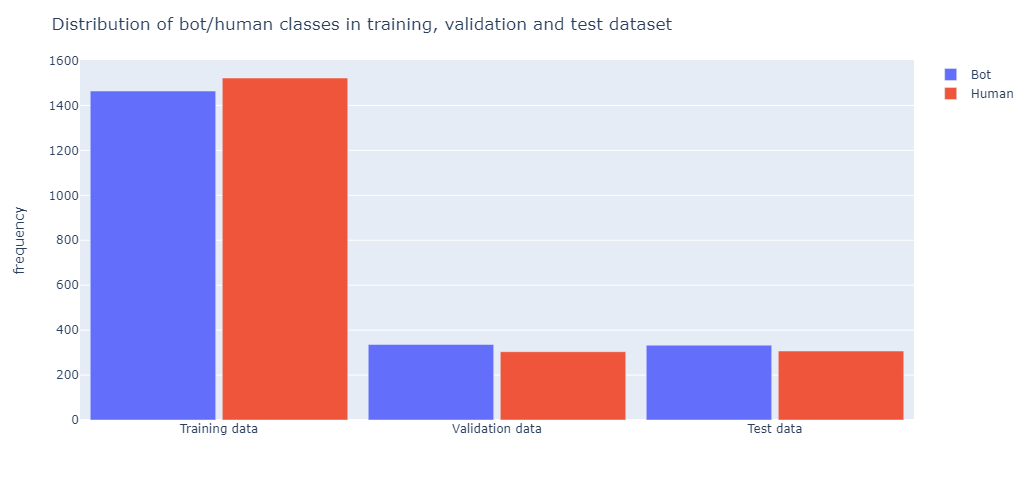

In [46]:
fig = px.bar(sdf, x="Set", y="Freq",
             color="Label", hover_data=['Label'],
             barmode = 'group')
fig.update_layout(
    title_text='Distribution of bot/human classes in training, validation and test dataset',
    xaxis_title_text='', #'subset',
    yaxis_title_text='frequency',
    bargap=0.05,
    bargroupgap=0.05,
    width=700,
    height=500,
    legend={"title":""})
fig.show()

## Distribution of other features in training dataset

### followers_count

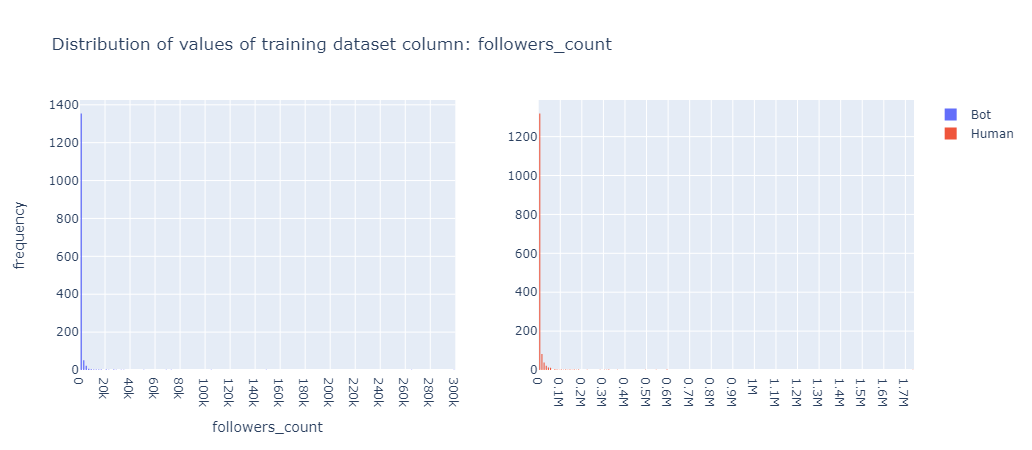

In [47]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='followers_count', dtick=20000),
    xaxis2=dict(showgrid=True, dtick=100000),
    yaxis=dict(showgrid=True))

fig.show()

#### followers_count - outliers

##### K-means (mnonot useful)

Number of outliers:  238


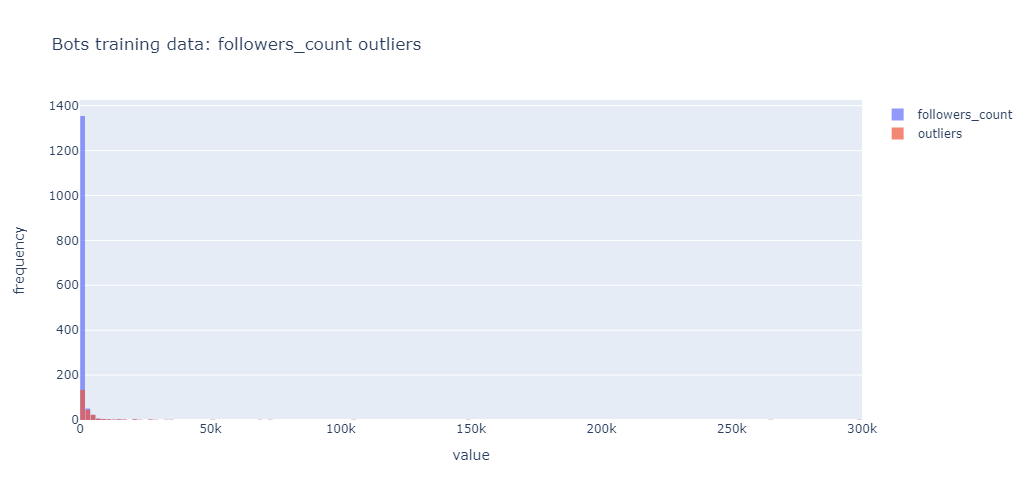

<Figure size 1500x700 with 0 Axes>

In [48]:
followers_count_bots_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==1], 'followers_count', title = "Bots training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

Number of outliers:  623


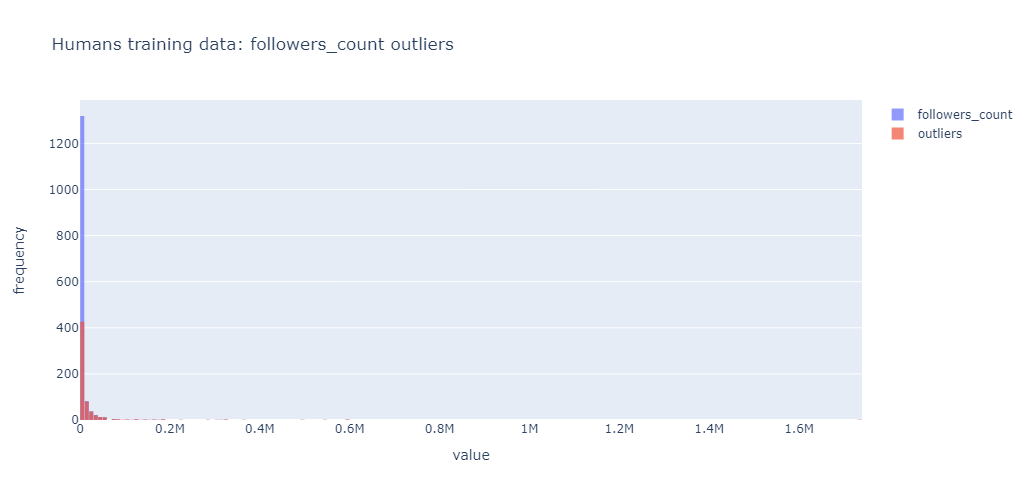

<Figure size 1500x700 with 0 Axes>

In [49]:
followers_count_humans_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==0], 'followers_count', title = "Humans training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

In [50]:
# q_hi_bots = train_data.loc[train_data['label']==1]['followers_count'].quantile(0.99, interpolation='nearest')
# q_hi_humans = train_data.loc[train_data['label']==0]['followers_count'].quantile(0.99, interpolation='nearest')

# df_filtered_bots = train_data.loc[train_data['label']==1][(train_data.loc[train_data['label']==1]['followers_count'] < q_hi_bots)]
# df_filtered_humans = train_data.loc[train_data['label']==0][(train_data.loc[train_data['label']==0]['followers_count'] < q_hi_humans)]

In [51]:
len(train_data[(train_data['label']==1)])

1464

In [52]:
len(train_data[(train_data['label']==0)])

1522

In [53]:
from scipy.stats import expon

# Fit an exponential distribution to data
loc_b, scale_b = expon.fit(train_data.loc[train_data['label']==1]['followers_count'])
loc_h, scale_h = expon.fit(train_data.loc[train_data['label']==0]['followers_count'])

# Calculate the 99th percentile using the percent-point function (inverse CDF)
percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
df_reduced_outliers_followers_count = train_data[((train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)) | ((train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans))]
df_filtered_bots = train_data[(train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)]
df_filtered_humans = train_data[(train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans)]

In [54]:
def df_99_percentile(df, column_name):
    # Fit an exponential distribution to data
    loc_b, scale_b = expon.fit(df.loc[df['label']==1][column_name])
    loc_h, scale_h = expon.fit(df.loc[df['label']==0][column_name])

    # Calculate the 99th percentile using the percent-point function (inverse CDF)
    percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
    percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
    return df[((df['label']==1) & (df[column_name] < percentile_99_bots)) | ((df['label']==0) & (df[column_name] < percentile_99_humans))]

In [55]:
len(df_filtered_bots)

1429

In [56]:
len(df_filtered_humans)

1469

In [57]:
len(df_reduced_outliers_followers_count) 

2898

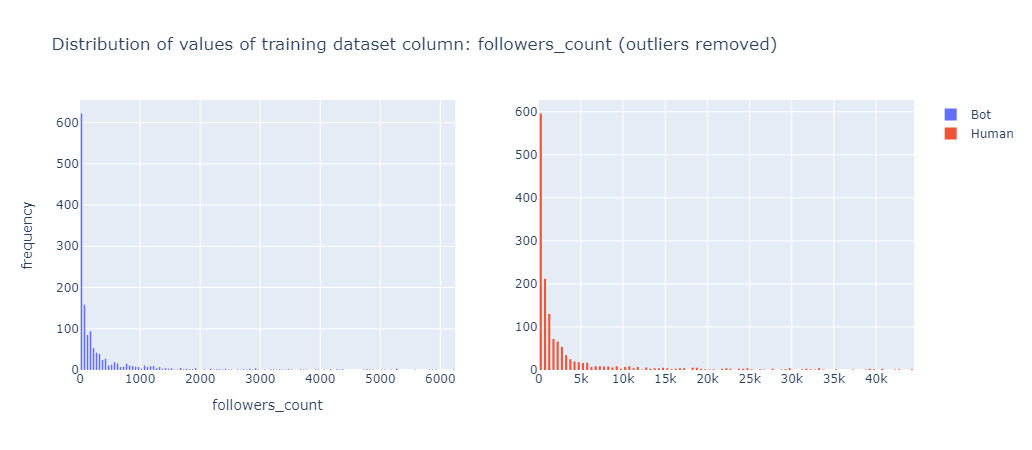

In [58]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count (outliers removed)',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000),
    xaxis2=dict(showgrid=True, dtick=5000),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count

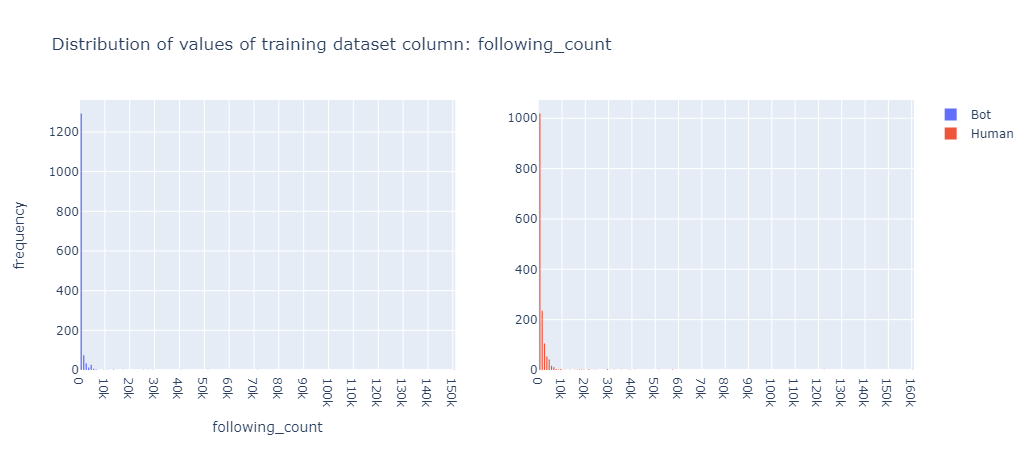

In [59]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10000),
    xaxis2=dict(showgrid=True, dtick=10000),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count - outliers

In [60]:
df_reduced_outliers_following_count = df_99_percentile(df=train_data, column_name='following_count')

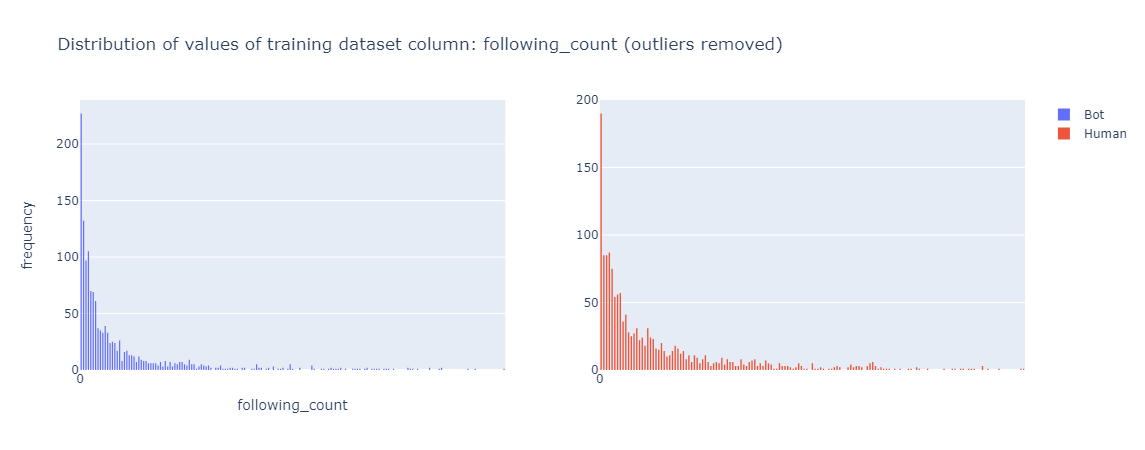

In [61]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count (outliers removed)',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000),
    xaxis2=dict(showgrid=True, dtick=1000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count

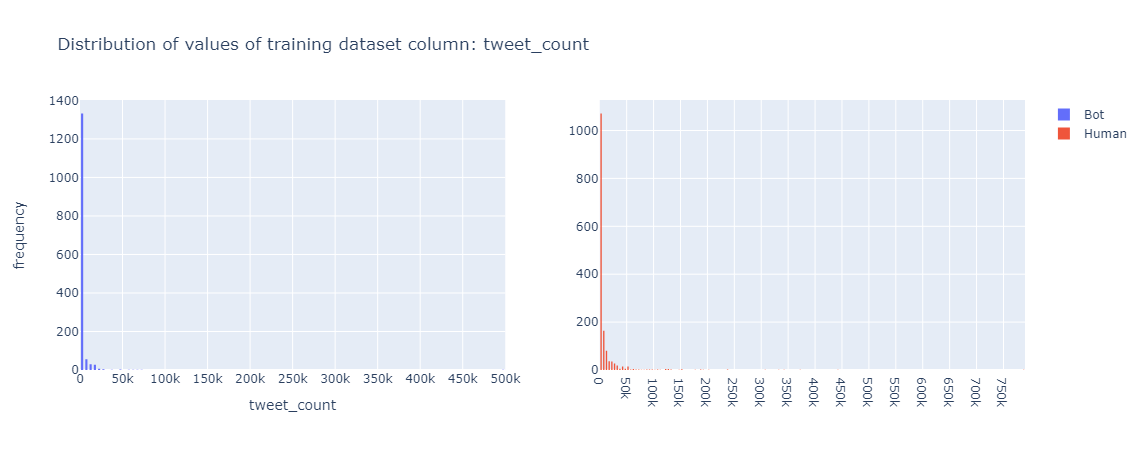

In [62]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=50000),
    xaxis2=dict(showgrid=True, dtick=50000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count - outliers

In [63]:
df_reduced_outliers_tweet_count = df_99_percentile(df=train_data, column_name='tweet_count')

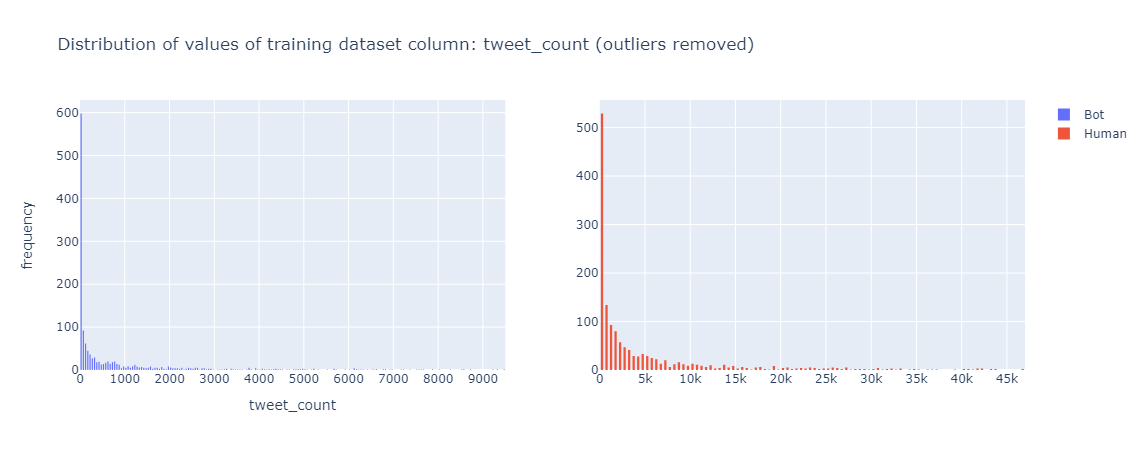

In [64]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count (outliers removed)',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000),
    xaxis2=dict(showgrid=True, dtick=5000),
    yaxis=dict(showgrid=True))

fig.show()

### descr_len

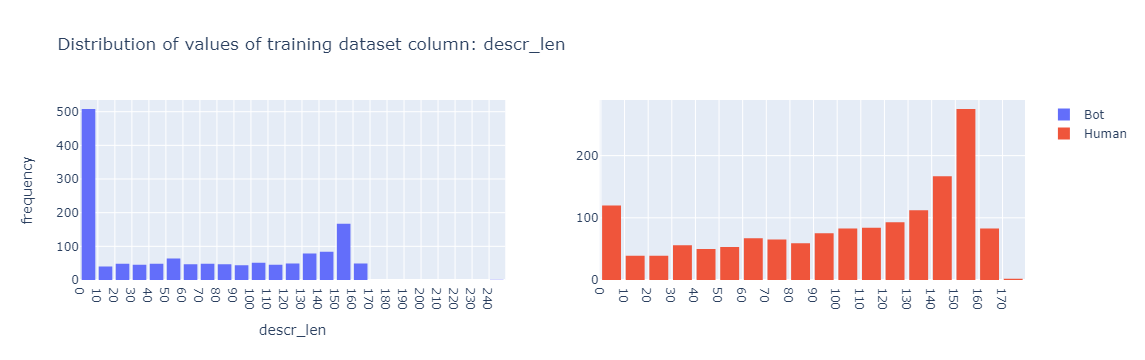

In [65]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_len - outliers

In [66]:
q_hi_bots1 = train_data.loc[train_data['label']==1]['descr_len'].quantile(0.99, interpolation='nearest')
q_hi_humans1 = train_data.loc[train_data['label']==0]['descr_len'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_descr_len =  train_data[((train_data['label']==1) & (train_data['descr_len'] < q_hi_bots1)) | ((train_data['label']==0) & (train_data['descr_len'] < q_hi_humans1))]

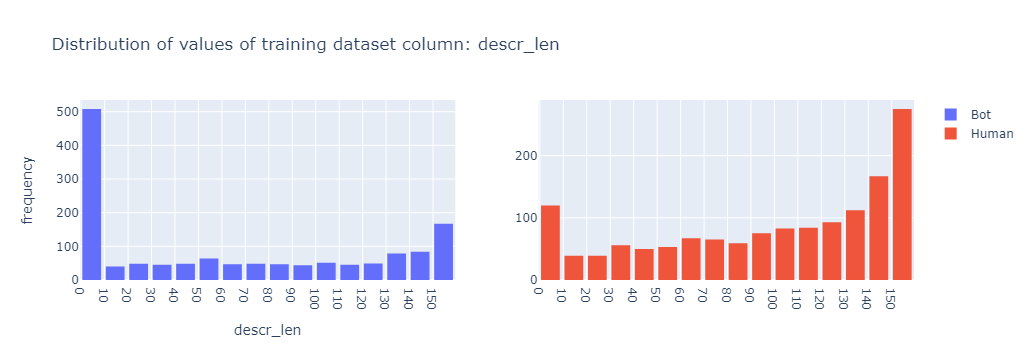

In [67]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

### account_age

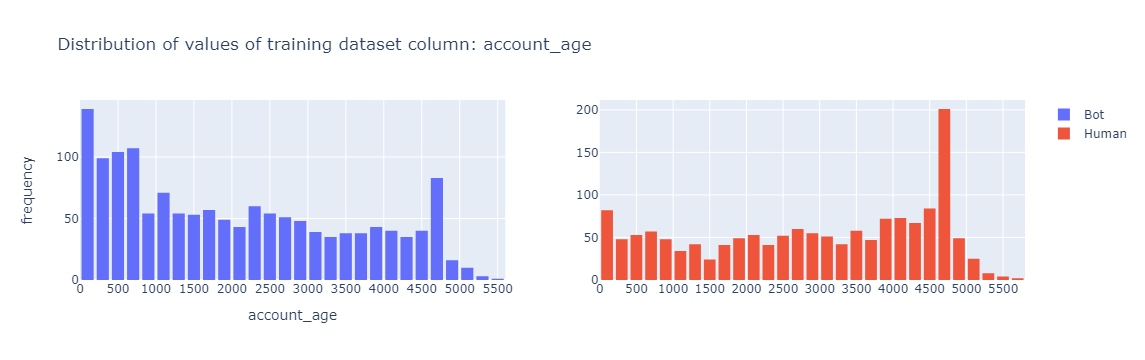

In [70]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500, range=[0, max(train_data['descr_len'])+5]),
    xaxis2=dict(showgrid=True, dtick=500, range=[0, max(train_data['descr_len'])+5]),
    yaxis=dict(showgrid=True))

fig.show()

#### account_age - outliers

In [71]:
q_hi_bots2 = train_data.loc[train_data['label']==1]['account_age'].quantile(0.99, interpolation='nearest')
q_hi_humans2 = train_data.loc[train_data['label']==0]['account_age'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_account_age =  train_data[((train_data['label']==1) & (train_data['account_age'] < q_hi_bots2)) | ((train_data['label']==0) & (train_data['account_age'] < q_hi_humans2))]

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_account_age.loc[df_reduced_outliers_account_age['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_account_age.loc[df_reduced_outliers_account_age['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500, range=[0, max(df_reduced_outliers_account_age['descr_len'])+5]),
    xaxis2=dict(showgrid=True, dtick=500, range=[0, max(df_reduced_outliers_account_age['descr_len'])+5]),
    yaxis=dict(showgrid=True))

fig.show()

### Create merged dataframe from reduced by columns outliers dataframes

In [72]:
# train_data_wo_outliers = df_reduced_outliers_followers_count.merge(df_reduced_outliers_following_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_tweet_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_len, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_account_age, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

train_data_wo_outliers = df_reduced_outliers_followers_count.merge(df_reduced_outliers_following_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

rest_of_df = [df_reduced_outliers_tweet_count, 
              df_reduced_outliers_descr_len, 
              df_reduced_outliers_account_age]

for df in rest_of_df:
    if (len(df.loc[df['label']==1]) > 0 and len(df.loc[df['label']==0]) > 0):
        train_data_wo_outliers = train_data_wo_outliers.merge(df, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [73]:
len(train_data)

2986

In [74]:
len(train_data_wo_outliers)

2571

In [75]:
train_data_wo_outliers

label            id  followers_count  tweet_count  following_count  \
0       1.0  1.241400e+18             31.0         64.0              6.0   
1       0.0  6.342788e+07            183.0        703.0            247.0   
2       0.0  3.852371e+07           2513.0         12.0           3603.0   
3       1.0  1.059518e+18              0.0          1.0             63.0   
4       0.0  3.341717e+08           5527.0      15710.0           5250.0   
...     ...           ...              ...          ...              ...   
2566    0.0  1.664355e+07           1317.0         62.0            981.0   
2567    1.0  2.165297e+09            178.0          1.0              0.0   
2568    0.0  3.520399e+09            302.0        215.0            231.0   
2569    0.0  3.431402e+09             85.0        142.0            226.0   
2570    1.0  1.487279e+18             55.0        350.0            218.0   

      account_age  descr_len  
0           725.0      149.0  
1          4605.0       93.0  
2          4696.0      113.0  
3          1227.0        0.0  
4          3900.0      123.0  
...           ...        ...  
2566       4907.0       37.0  
2567       3059.0       63.0  
2568       2379.0       50.0  
2569       2401.0      112.0  
2570         46.0       94.0  

[2571 rows x 7 columns]

#### Drop 'id' column

In [76]:
train_data = train_data.drop(['id'], axis=1)
val_data = val_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)

train_data_wo_outliers = train_data_wo_outliers.drop(['id'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['id'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['id'], axis=1)

### Filter to have the same number of records for each class - part II

In [77]:
train_data = filter_df_for_balanced_classes(train_data, bot_label_value=1, human_label_value=0)
val_data = filter_df_for_balanced_classes(val_data, bot_label_value=1, human_label_value=0)
test_data = filter_df_for_balanced_classes(test_data, bot_label_value=1, human_label_value=0)

Number of bots:  1464
Number of human users:  1464
Number of bots:  304
Number of human users:  304
Number of bots:  307
Number of human users:  307


In [78]:
train_data_wo_outliers = filter_df_for_balanced_classes(train_data_wo_outliers, bot_label_value=1, human_label_value=0)
val_data_wo_outliers = filter_df_for_balanced_classes(val_data_wo_outliers, bot_label_value=1, human_label_value=0)
test_data_wo_outliers = filter_df_for_balanced_classes(test_data_wo_outliers, bot_label_value=1, human_label_value=0)

Number of bots:  1275
Number of human users:  1275
Number of bots:  304
Number of human users:  304
Number of bots:  307
Number of human users:  307


### Normalize data by column range of training set

In [79]:
columns_to_normalize = ['followers_count', 'following_count', 'tweet_count', 'descr_len', 'account_age']

In [80]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(train_data[columns_to_normalize])

train_data[columns_to_normalize] = min_max_scaler.transform(train_data[columns_to_normalize])
val_data[columns_to_normalize]   = min_max_scaler.transform(val_data[columns_to_normalize])
test_data[columns_to_normalize]  = min_max_scaler.transform(test_data[columns_to_normalize])

In [81]:
min_max_scaler_outliers = MinMaxScaler()
min_max_scaler_outliers.fit(train_data_wo_outliers[columns_to_normalize])

train_data_wo_outliers[columns_to_normalize] = min_max_scaler_outliers.transform(train_data_wo_outliers[columns_to_normalize])
val_data_wo_outliers[columns_to_normalize]   = min_max_scaler_outliers.transform(val_data_wo_outliers[columns_to_normalize])
test_data_wo_outliers[columns_to_normalize]  = min_max_scaler_outliers.transform(test_data_wo_outliers[columns_to_normalize])

## Correlation

In [82]:
sns.set(font_scale=2)

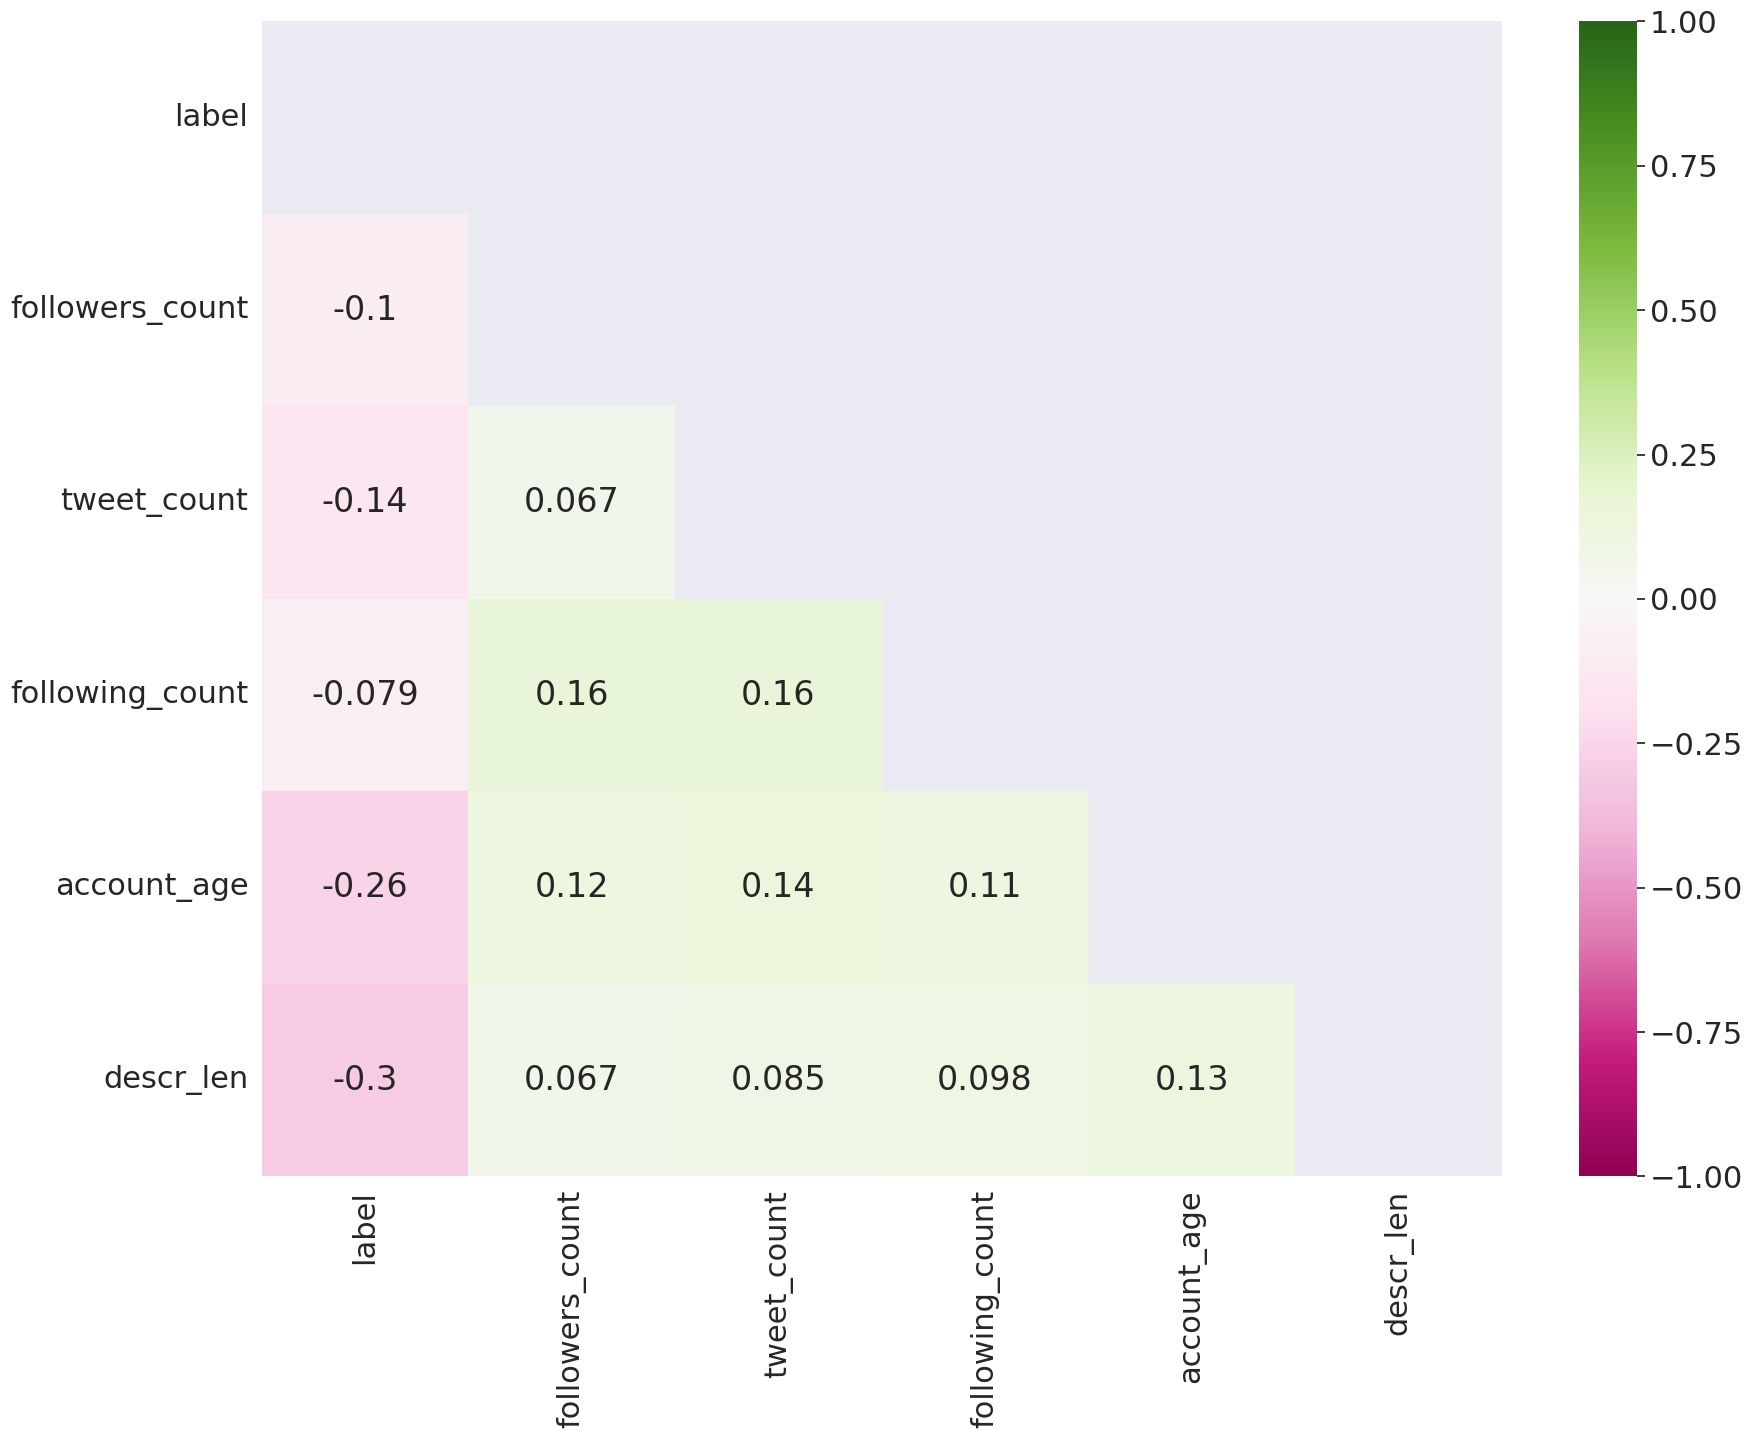

In [83]:
corr_threshold = 0.52
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(20, 15))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
         high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [84]:
sns.set(font_scale=1)

In [85]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 0


[]

In [86]:
train_data

label  followers_count  tweet_count  following_count  account_age  \
3770    1.0         0.000018     0.000081         0.000037     0.125581   
477     0.0         0.000106     0.000893         0.001536     0.818685   
526     0.0         0.001452     0.000015         0.022406     0.834941   
8712    1.0         0.000000     0.000001         0.000392     0.215255   
1452    0.0         0.003194     0.019946         0.032648     0.692747   
...     ...              ...          ...              ...          ...   
5727    1.0         0.000002     0.000027         0.000330     0.030725   
1924    1.0         0.001907     0.002552         0.026622     0.469811   
1970    1.0         0.000103     0.000001         0.000000     0.542515   
3817    1.0         0.015274     0.019648         0.000000     0.849946   
2191    1.0         0.000032     0.000444         0.001356     0.004287   

      descr_len  
3770   0.613169  
477    0.382716  
526    0.465021  
8712   0.000000  
1452   0.506173  
...         ...  
5727   0.300412  
1924   0.160494  
1970   0.259259  
3817   0.000000  
2191   0.386831  

[2928 rows x 6 columns]

In [87]:
# train_data = train_data.drop(['listed_count'], axis=1)
# val_data = val_data.drop(['listed_count'], axis=1)
# test_data = test_data.drop(['listed_count'], axis=1)

# train_data = train_data.drop(['has_description'], axis=1)
# val_data = val_data.drop(['has_description'], axis=1)
# test_data = test_data.drop(['has_description'], axis=1)

### Correlation of data reduced by outliers

#### First drop columns in filter (without outliers) dataframe where now have same value in whole column

In [88]:
same_data_columns = list(train_data_wo_outliers.columns[train_data_wo_outliers.apply(lambda x: x.nunique()) == 1])
same_data_columns

[]

In [89]:
train_data_wo_outliers = train_data_wo_outliers.drop(same_data_columns, axis=1)

val_data_wo_outliers = val_data_wo_outliers.drop(same_data_columns, axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(same_data_columns, axis=1)

#### Correlation

In [90]:
sns.set(font_scale=2)

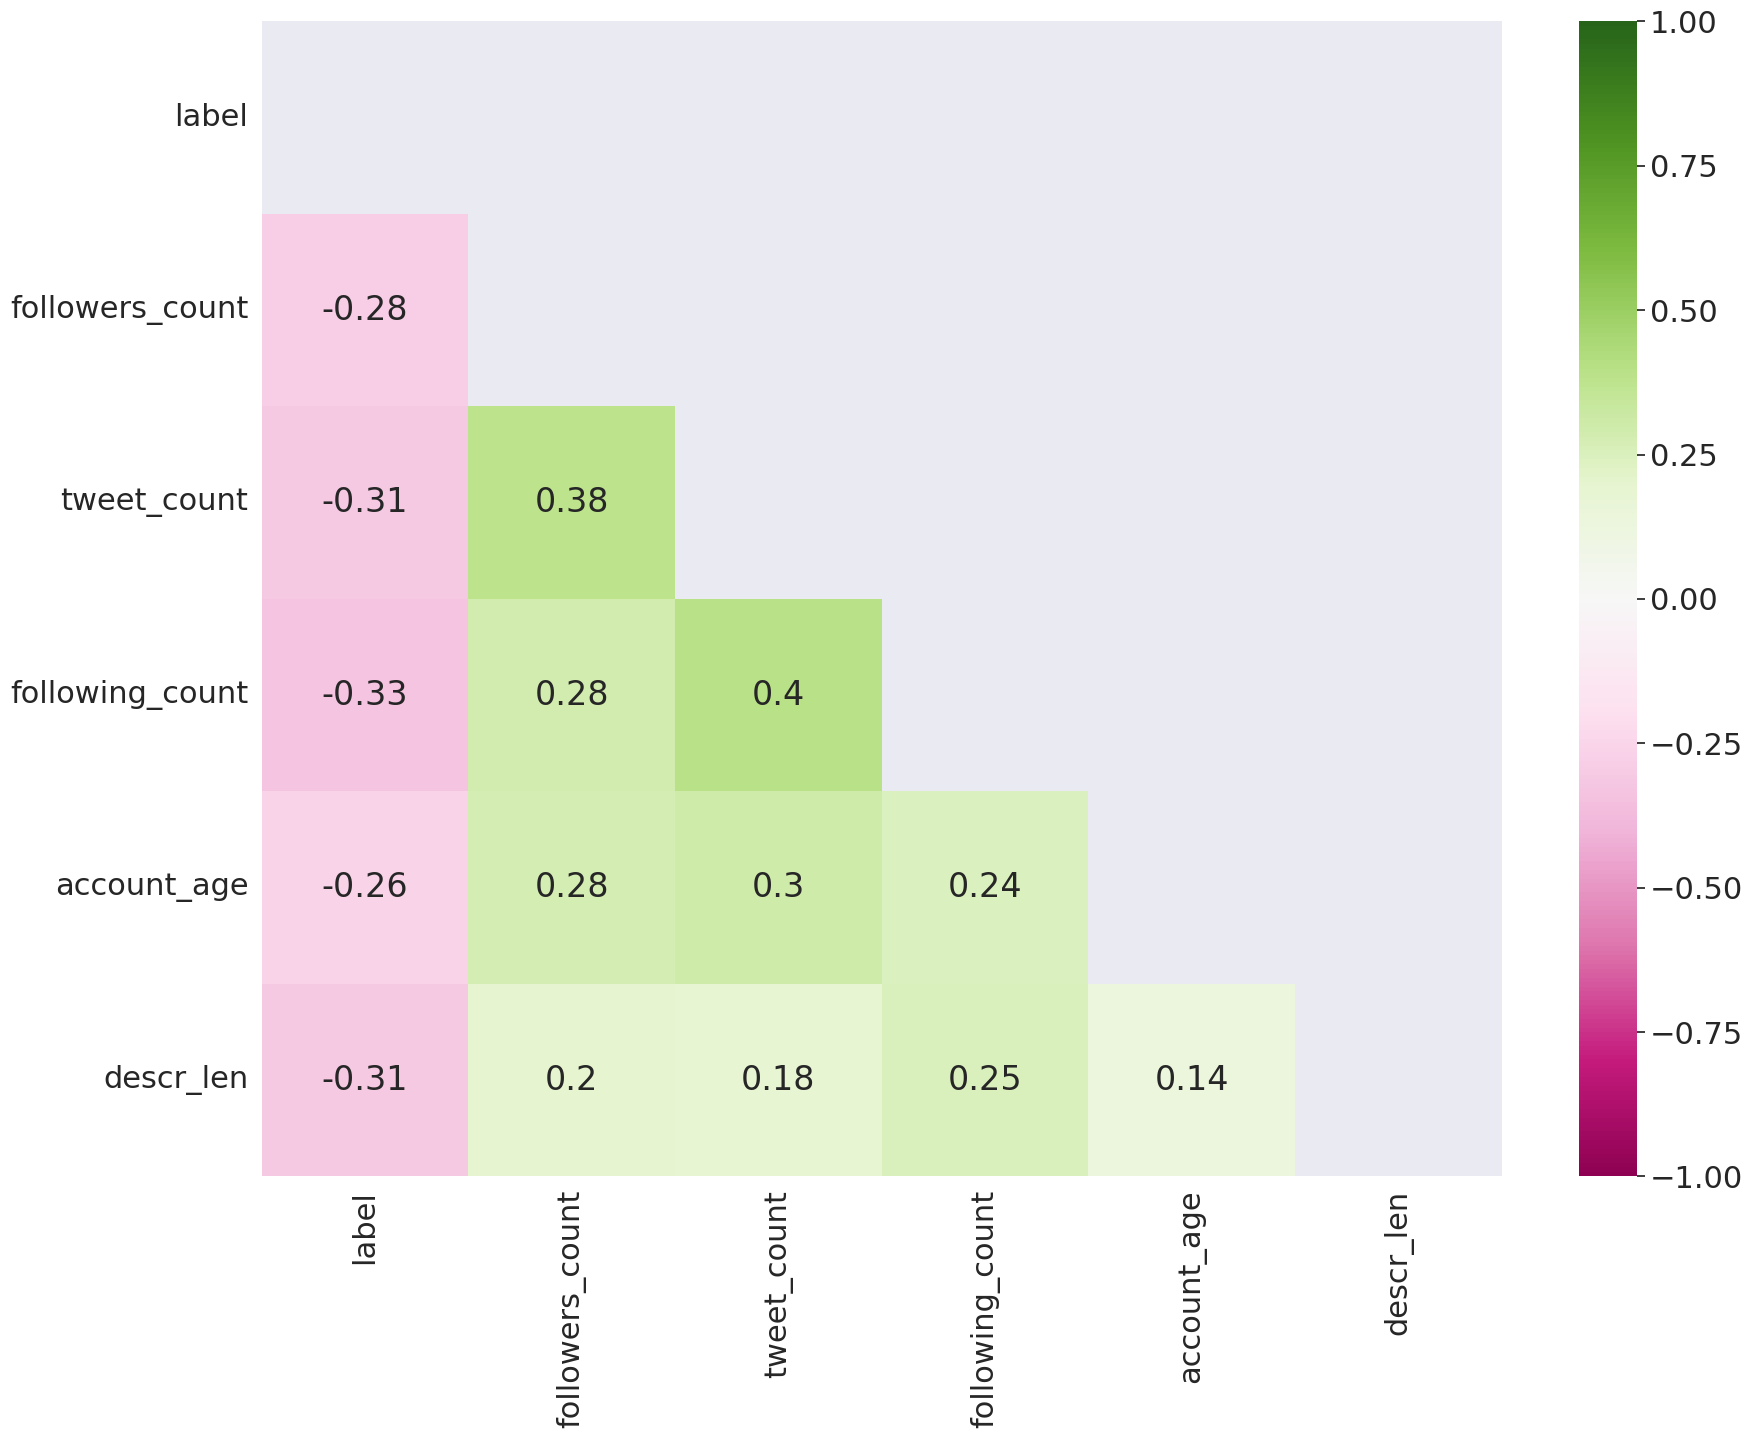

In [91]:
corr_threshold2 = 0.52
corr2 = train_data_wo_outliers.corr()
lower_tri2 = corr2.where(np.tril(np.ones(corr2.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(20, 15))
sns.heatmap(lower_tri2, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr2 = []
for column in train_data_wo_outliers:
   for col in train_data_wo_outliers:
     if abs(lower_tri2[column][col]) > corr_threshold2:
         high_corr2.append((column, col, lower_tri2[column][col]))
high_corr2 = sorted(high_corr2, key=lambda x: x[2], reverse=True)

In [92]:
f = plt.figure(figsize=(50, 40))
sns.set(font_scale=1)

<Figure size 5000x4000 with 0 Axes>

#### Drop column with higher correlation

In [93]:
high_corr2

[]

In [94]:
# train_data_wo_outliers = train_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)
# val_data_wo_outliers = val_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)
# test_data_wo_outliers = test_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)

#### Split data for input and output

In [95]:
train_X = train_data.drop(['label'], axis=1)
train_Y = pd.concat([train_data['label']], axis=1)
val_X = val_data.drop(['label'], axis=1)
val_Y = pd.concat([val_data['label']], axis=1)
test_X = test_data.drop(['label'], axis=1)
test_Y = pd.concat([test_data['label']], axis=1)


train_data_wo_outliers_X = train_data_wo_outliers.drop(['label'], axis=1)
train_data_wo_outliers_Y = pd.concat([train_data_wo_outliers['label']], axis=1)
val_data_wo_outliers_X = val_data_wo_outliers.drop(['label'], axis=1)
val_data_wo_outliers_Y = pd.concat([val_data_wo_outliers['label']], axis=1)
test_data_wo_outliers_X = test_data_wo_outliers.drop(['label'], axis=1)
test_data_wo_outliers_Y = pd.concat([test_data_wo_outliers['label']], axis=1)

# DNN models

#### Function to load a saved neural network model

In [96]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [97]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [98]:
def create_confusion_matrix(test_Y, out_Y):
    cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure()
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    sns.heatmap(
        cm,
        annot=labels,
        annot_kws={"size": 12},
        fmt='',
        cmap=plt.cm.Blues,
        cbar=False
    )
    ax.set_title("Confusion matrix", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    
    fig.show()

## Neural network models 

In [99]:
# EarlyStopping
def early_stop(metric='val_accuracy', mode = 'max', patience=50):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode=mode)
# PlotLosses
def plot_losses():
    return PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [100]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses(),
                           early_stop(),
                           checkpoint_callback(model_name)])
    return model

## Model 1.

#### Create model

In [101]:
def create_model_1(shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
  model = Sequential()
  model.add(Input(shape=shape)),
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

2023-08-21 23:49:54.507826: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-21 23:49:54.507884: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-21 23:49:54.507919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (668ede5dda1a): /proc/driver/nvidia/version does not exist
2023-08-21 23:49:54.509505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

### batch_size=10, epochs=200

#### Create and train model

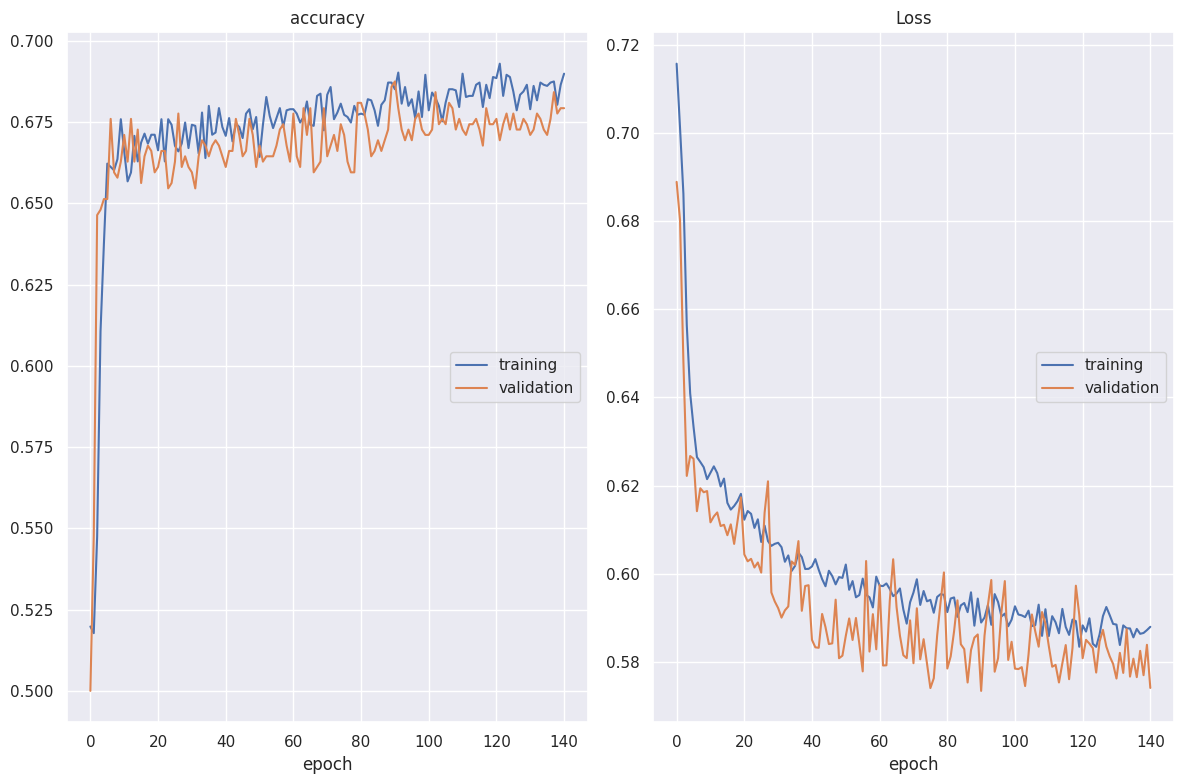

accuracy
	training         	 (min:    0.518, max:    0.693, cur:    0.690)
	validation       	 (min:    0.500, max:    0.688, cur:    0.679)
Loss
	training         	 (min:    0.583, max:    0.716, cur:    0.588)
	validation       	 (min:    0.573, max:    0.689, cur:    0.574)

Epoch 141: val_accuracy did not improve from 0.68750
293/293 [==============================] - 1s 5ms/step - loss: 0.5880 - accuracy: 0.6899 - val_loss: 0.5741 - val_accuracy: 0.6793


In [102]:
model_name = 'model_users_only_10000_1_v1_batch_size_10_epochs_200_only_import_feat_norm'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=10, epochs=200)

#### Prediction and results

Accuracy: 0.7003257328990228
Precision: [0.6858006  0.71731449]
Recall: 0.6612377850162866
F1 score: 0.688136
ROC AUC: 0.700326


(0.7003257328990228,
 array([0.6858006 , 0.71731449]),
 0.6612377850162866,
 0.6881355932203389,
 0.7003257328990227)

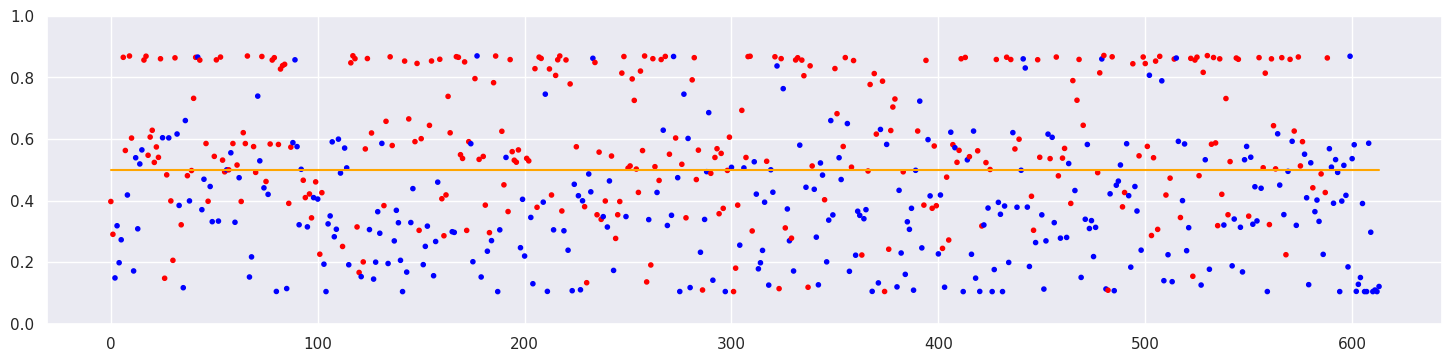

<Figure size 640x480 with 0 Axes>

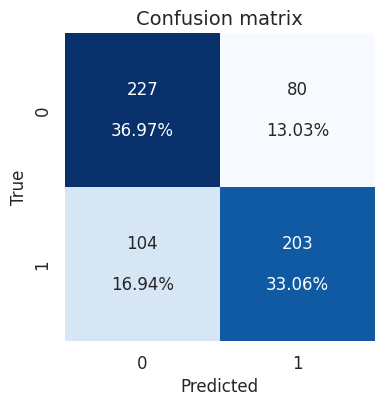

In [103]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=50, epochs=200

In [104]:
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
print(model1_v1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                192       
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

### Train model

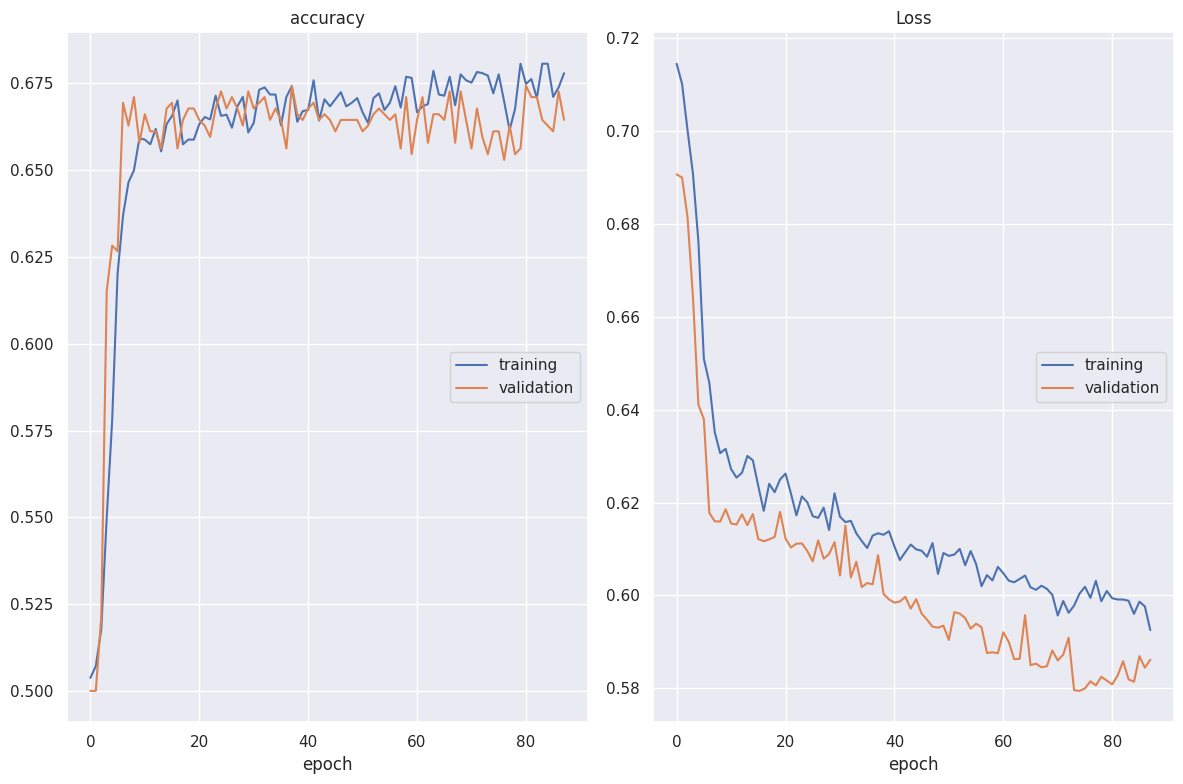

accuracy
	training         	 (min:    0.504, max:    0.681, cur:    0.678)
	validation       	 (min:    0.500, max:    0.674, cur:    0.664)
Loss
	training         	 (min:    0.593, max:    0.714, cur:    0.593)
	validation       	 (min:    0.579, max:    0.691, cur:    0.586)

Epoch 88: val_accuracy did not improve from 0.67434
59/59 [==============================] - 1s 12ms/step - loss: 0.5925 - accuracy: 0.6779 - val_loss: 0.5862 - val_accuracy: 0.6645


In [105]:
model_name = 'model_users_only_10000_1_v1_batch_size_50_epochs_200_only_import_feat_norm'
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=50, epochs=200)

In [106]:
# Load model
# model = load_model_from_file(models_path + '/model_name.hdf5')

#### Prediction

In [107]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

#### Results

(0.0, 1.0)

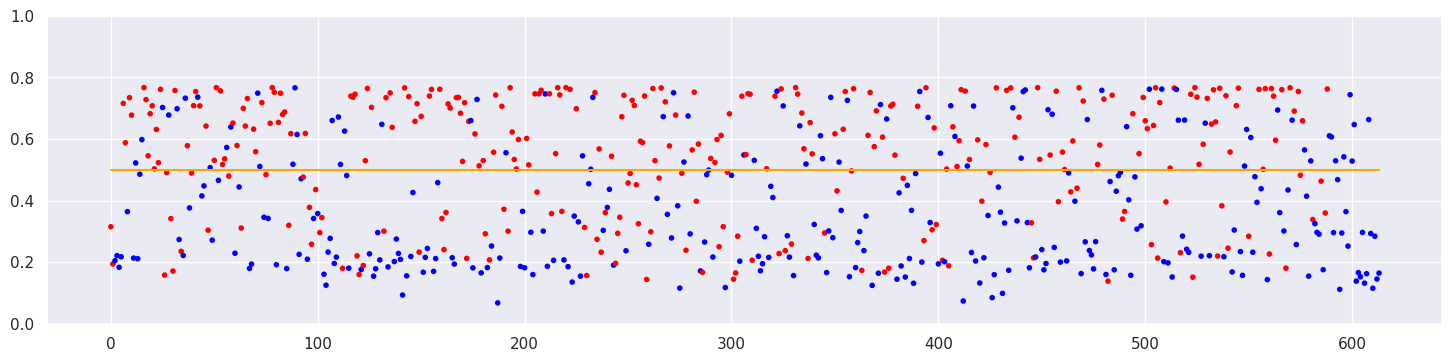

In [108]:
x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

#### Confusion matrix

Accuracy: 0.7003257328990228
Precision: [0.68693009 0.71578947]
Recall: 0.6644951140065146
F1 score: 0.689189
ROC AUC: 0.700326


(0.7003257328990228,
 array([0.68693009, 0.71578947]),
 0.6644951140065146,
 0.6891891891891893,
 0.7003257328990228)

<Figure size 640x480 with 0 Axes>

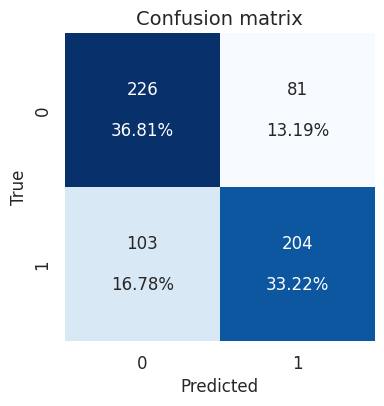

In [109]:
create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=100, epochs=200

#### Create and train model

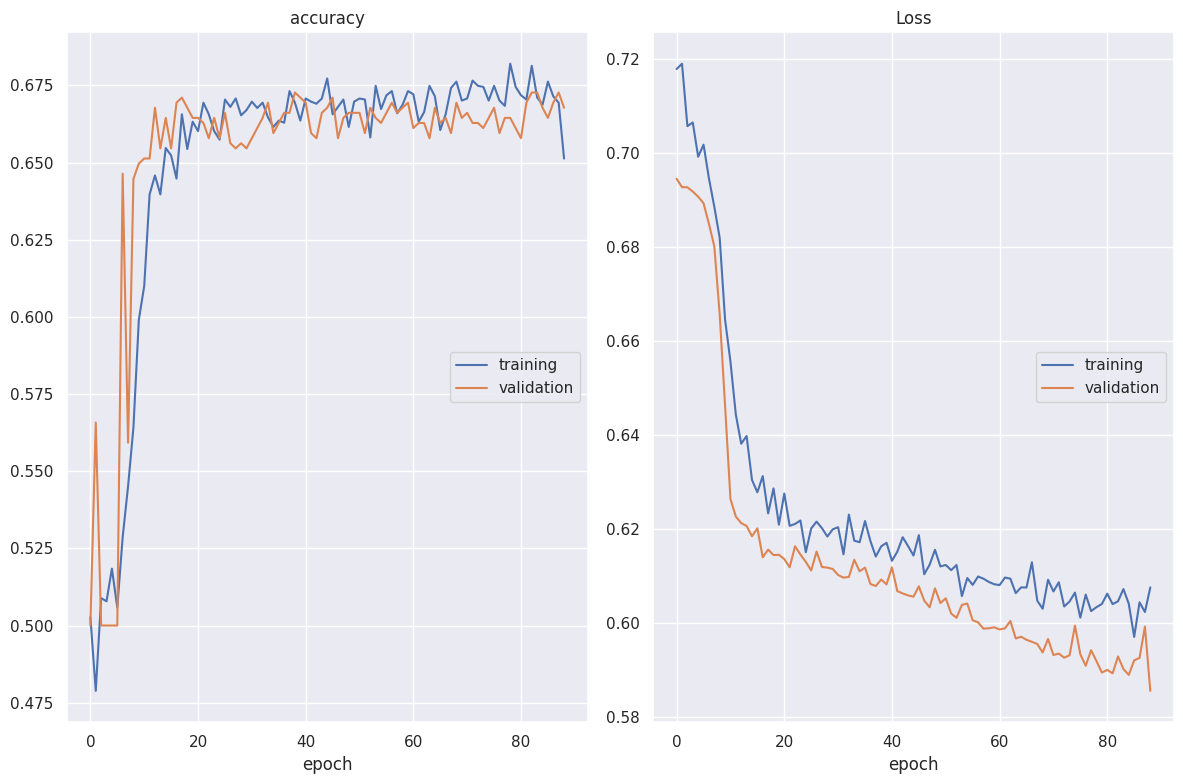

accuracy
	training         	 (min:    0.479, max:    0.682, cur:    0.651)
	validation       	 (min:    0.500, max:    0.673, cur:    0.668)
Loss
	training         	 (min:    0.597, max:    0.719, cur:    0.608)
	validation       	 (min:    0.586, max:    0.695, cur:    0.586)

Epoch 89: val_accuracy did not improve from 0.67270
30/30 [==============================] - 1s 23ms/step - loss: 0.6076 - accuracy: 0.6513 - val_loss: 0.5856 - val_accuracy: 0.6678


In [110]:
model_name = 'model_users_only_10000_1_v1_batch_size_100_epochs_200_only_import_feat_norm'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=100, epochs=200)

#### Prediction and results

Accuracy: 0.6970684039087948
Precision: [0.7037037  0.69085174]
Recall: 0.7133550488599348
F1 score: 0.701923
ROC AUC: 0.697068


(0.6970684039087948,
 array([0.7037037 , 0.69085174]),
 0.7133550488599348,
 0.701923076923077,
 0.6970684039087948)

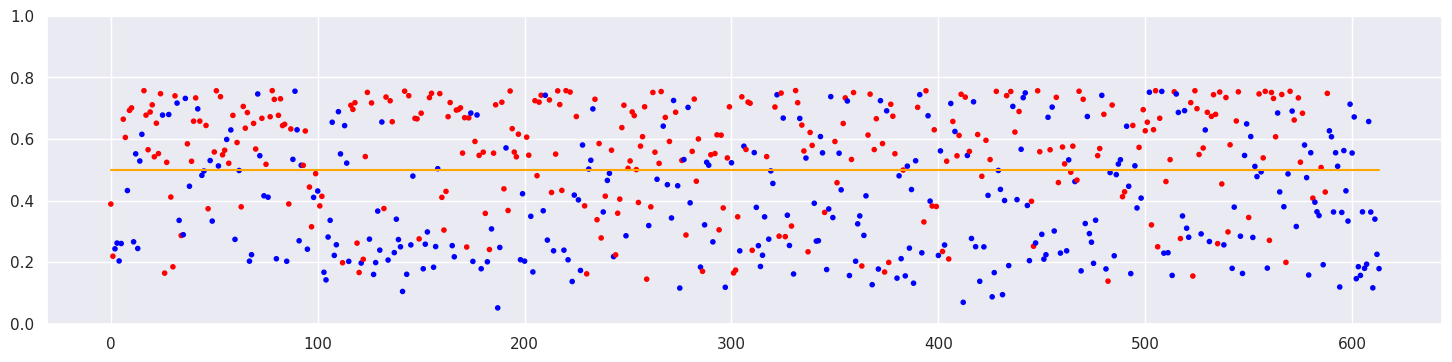

<Figure size 640x480 with 0 Axes>

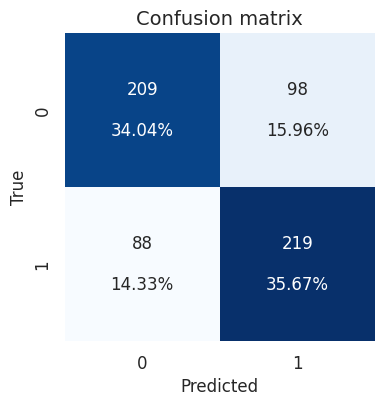

In [111]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=150, epochs=200

#### Create and train model

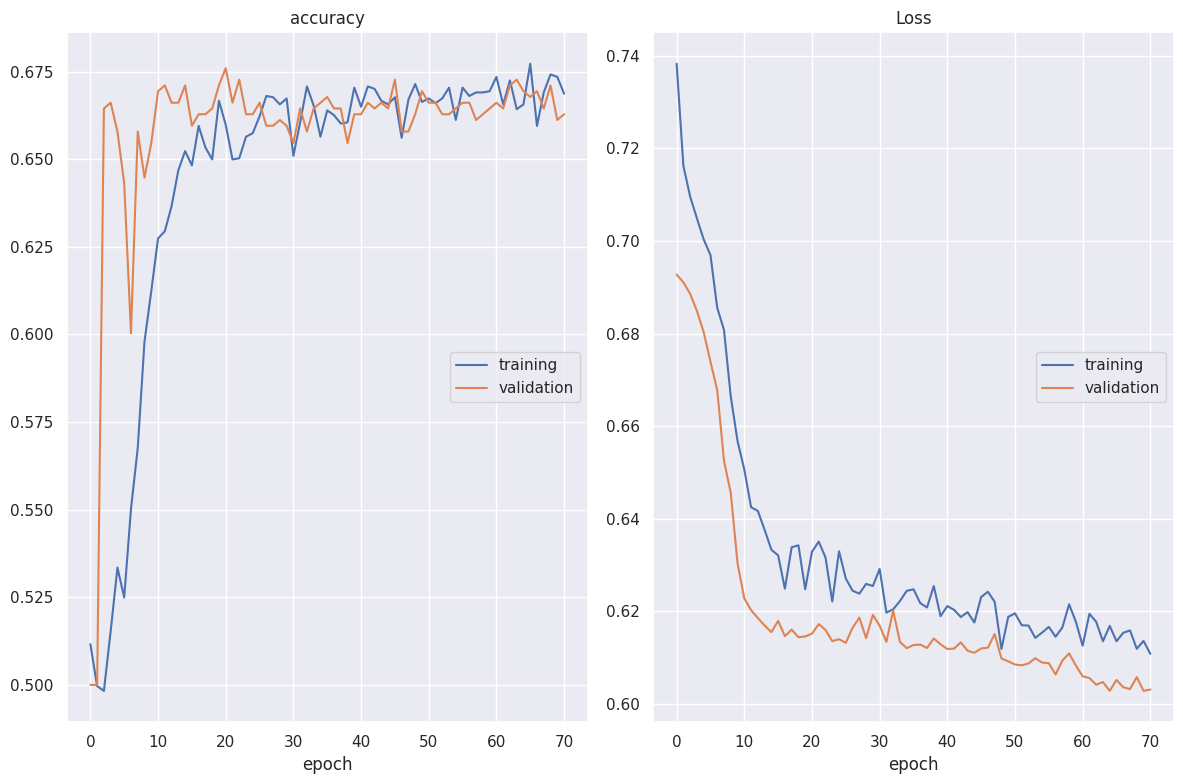

accuracy
	training         	 (min:    0.498, max:    0.677, cur:    0.669)
	validation       	 (min:    0.500, max:    0.676, cur:    0.663)
Loss
	training         	 (min:    0.611, max:    0.738, cur:    0.611)
	validation       	 (min:    0.603, max:    0.693, cur:    0.603)

Epoch 71: val_accuracy did not improve from 0.67599
20/20 [==============================] - 1s 36ms/step - loss: 0.6108 - accuracy: 0.6687 - val_loss: 0.6031 - val_accuracy: 0.6628


In [112]:
model_name = 'model_users_only_10000_1_v1_batch_size_150_epochs_200_only_import_feat_norm'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=150, epochs=200)

#### Prediction and results

Accuracy: 0.7019543973941368
Precision: [0.68674699 0.71985816]
Recall: 0.6612377850162866
F1 score: 0.689304
ROC AUC: 0.701954


(0.7019543973941368,
 array([0.68674699, 0.71985816]),
 0.6612377850162866,
 0.6893039049235994,
 0.7019543973941367)

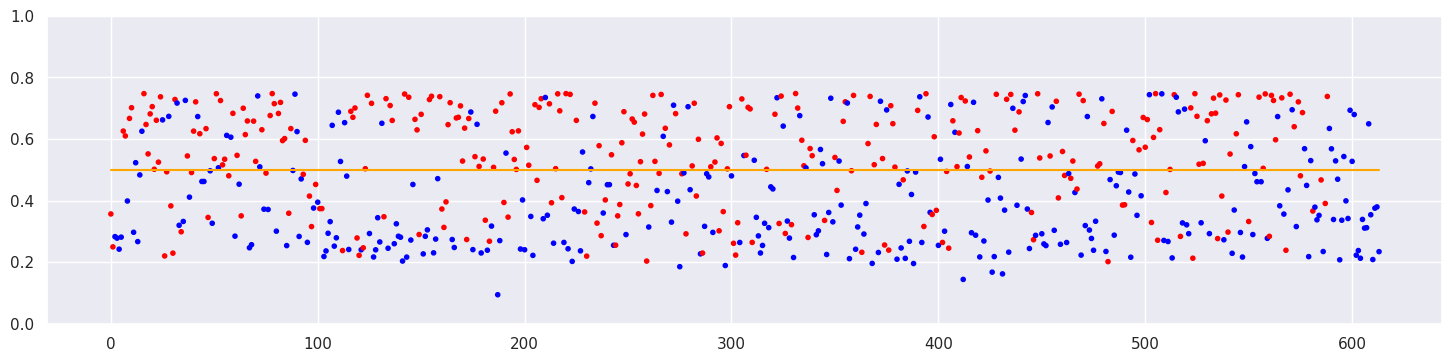

<Figure size 640x480 with 0 Axes>

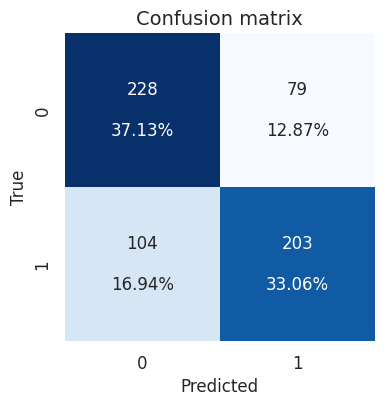

In [113]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=200, epochs=200

#### Create and train model

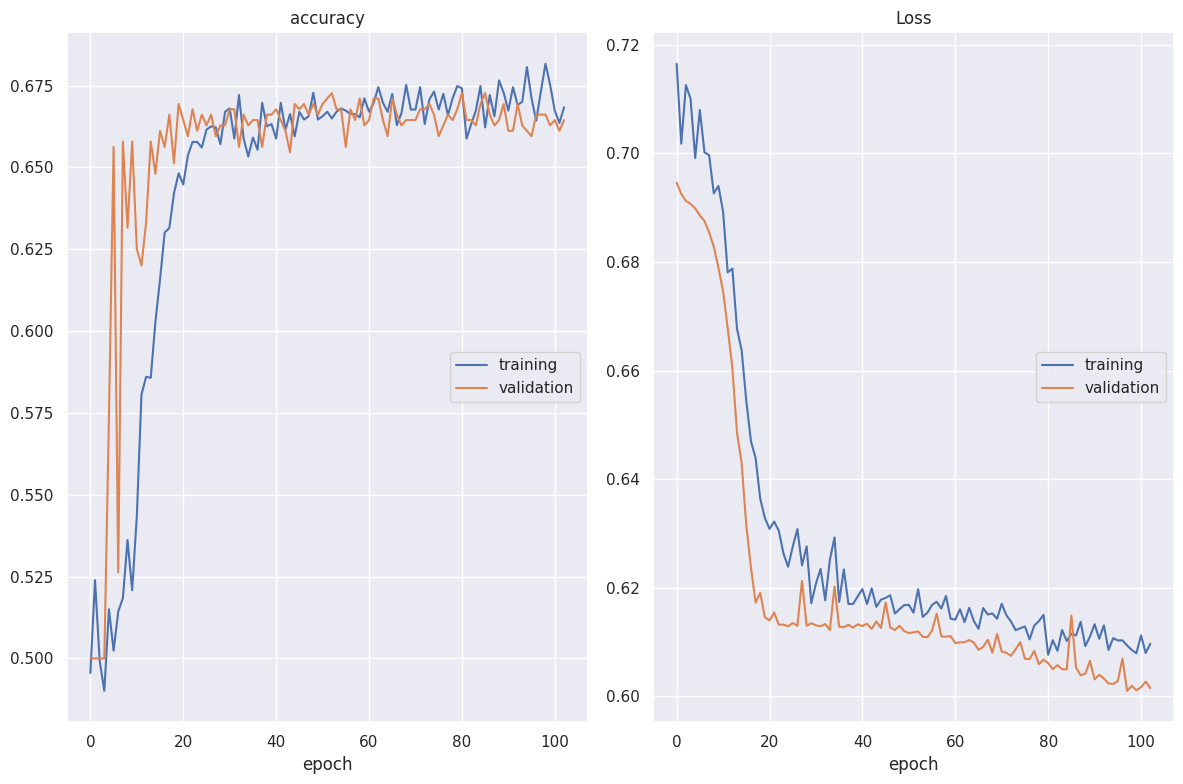

accuracy
	training         	 (min:    0.490, max:    0.682, cur:    0.668)
	validation       	 (min:    0.500, max:    0.673, cur:    0.664)
Loss
	training         	 (min:    0.608, max:    0.717, cur:    0.610)
	validation       	 (min:    0.601, max:    0.695, cur:    0.602)

Epoch 103: val_accuracy did not improve from 0.67270
15/15 [==============================] - 1s 48ms/step - loss: 0.6097 - accuracy: 0.6684 - val_loss: 0.6015 - val_accuracy: 0.6645


In [114]:
model_name = 'model_users_only_10000_1_v1_batch_size_200_epochs_200_only_import_feat_norm'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=200, epochs=200)

#### Prediction and results

Accuracy: 0.6921824104234527
Precision: [0.70629371 0.67987805]
Recall: 0.7263843648208469
F1 score: 0.702362
ROC AUC: 0.692182


(0.6921824104234527,
 array([0.70629371, 0.67987805]),
 0.7263843648208469,
 0.7023622047244094,
 0.6921824104234527)

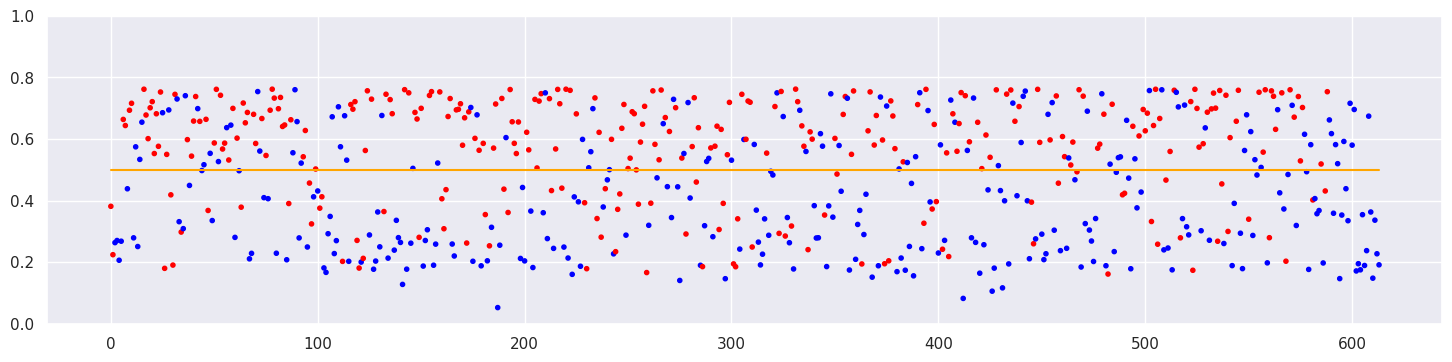

<Figure size 640x480 with 0 Axes>

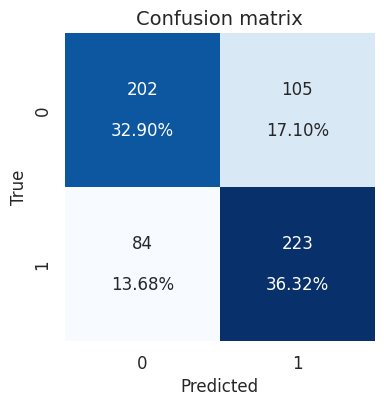

In [115]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=250, epochs=200

#### Create and train model

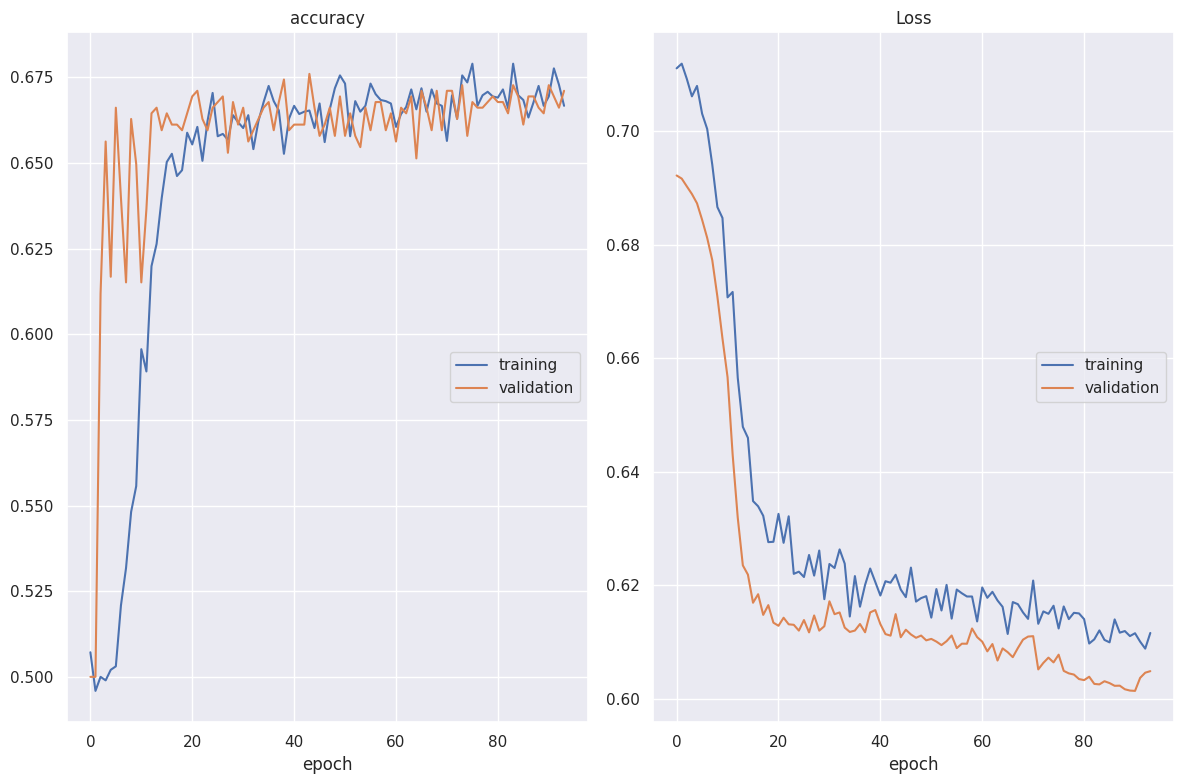

accuracy
	training         	 (min:    0.496, max:    0.679, cur:    0.667)
	validation       	 (min:    0.500, max:    0.676, cur:    0.671)
Loss
	training         	 (min:    0.609, max:    0.712, cur:    0.612)
	validation       	 (min:    0.601, max:    0.692, cur:    0.605)

Epoch 94: val_accuracy did not improve from 0.67599
12/12 [==============================] - 1s 56ms/step - loss: 0.6116 - accuracy: 0.6667 - val_loss: 0.6049 - val_accuracy: 0.6711


In [116]:
model_name = 'model_users_only_10000_1_v1_batch_size_250_epochs_200_only_import_feat_norm'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=250, epochs=200)

#### Prediction and results

Accuracy: 0.7019543973941368
Precision: [0.68902439 0.71678322]
Recall: 0.6677524429967426
F1 score: 0.691400
ROC AUC: 0.701954


(0.7019543973941368,
 array([0.68902439, 0.71678322]),
 0.6677524429967426,
 0.6913996627318718,
 0.7019543973941368)

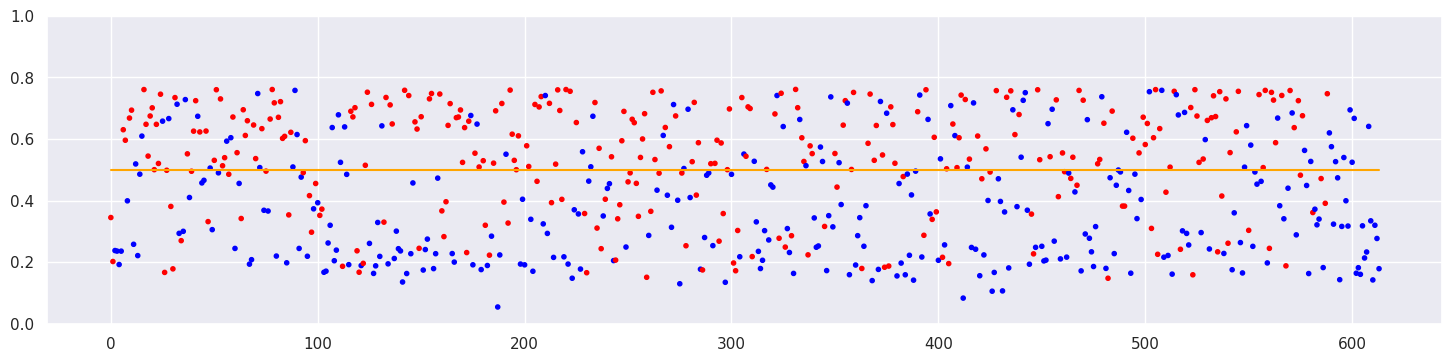

<Figure size 640x480 with 0 Axes>

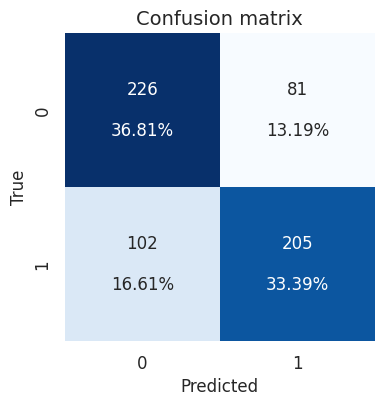

In [117]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### Model 1. - version for data reduced by outliers

### batch_size=10, epochs=200

#### Create and train model

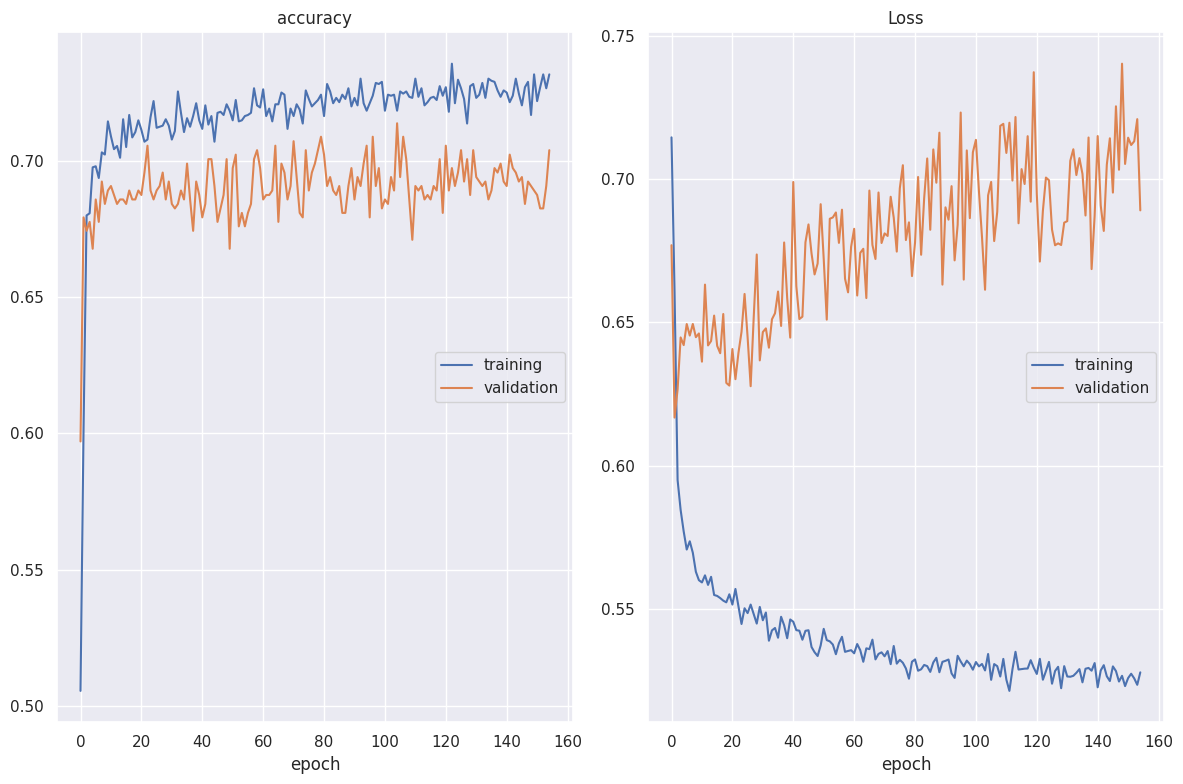

accuracy
	training         	 (min:    0.505, max:    0.736, cur:    0.732)
	validation       	 (min:    0.597, max:    0.714, cur:    0.704)
Loss
	training         	 (min:    0.522, max:    0.715, cur:    0.528)
	validation       	 (min:    0.617, max:    0.740, cur:    0.689)

Epoch 155: val_accuracy did not improve from 0.71382
255/255 [==============================] - 1s 5ms/step - loss: 0.5280 - accuracy: 0.7318 - val_loss: 0.6891 - val_accuracy: 0.7039


In [118]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_10_epochs_200_only_import_feat_norm'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=10, epochs=200)

#### Prediction and results

Accuracy: 0.7149837133550488
Precision: [0.73076923 0.70121951]
Recall: 0.749185667752443
F1 score: 0.724409
ROC AUC: 0.714984


(0.7149837133550488,
 array([0.73076923, 0.70121951]),
 0.749185667752443,
 0.7244094488188977,
 0.7149837133550488)

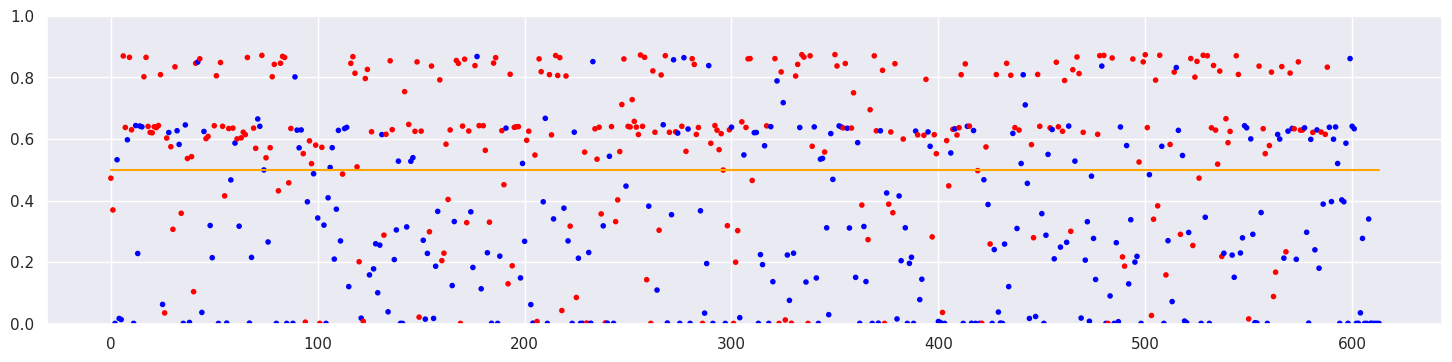

<Figure size 640x480 with 0 Axes>

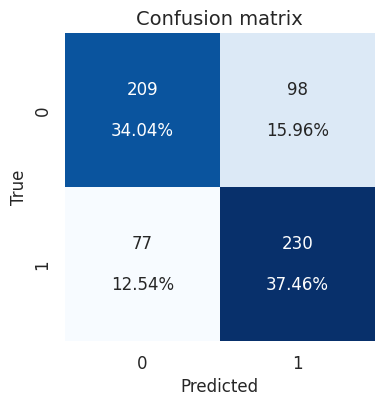

In [119]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=50, epochs=200

#### Create and train model

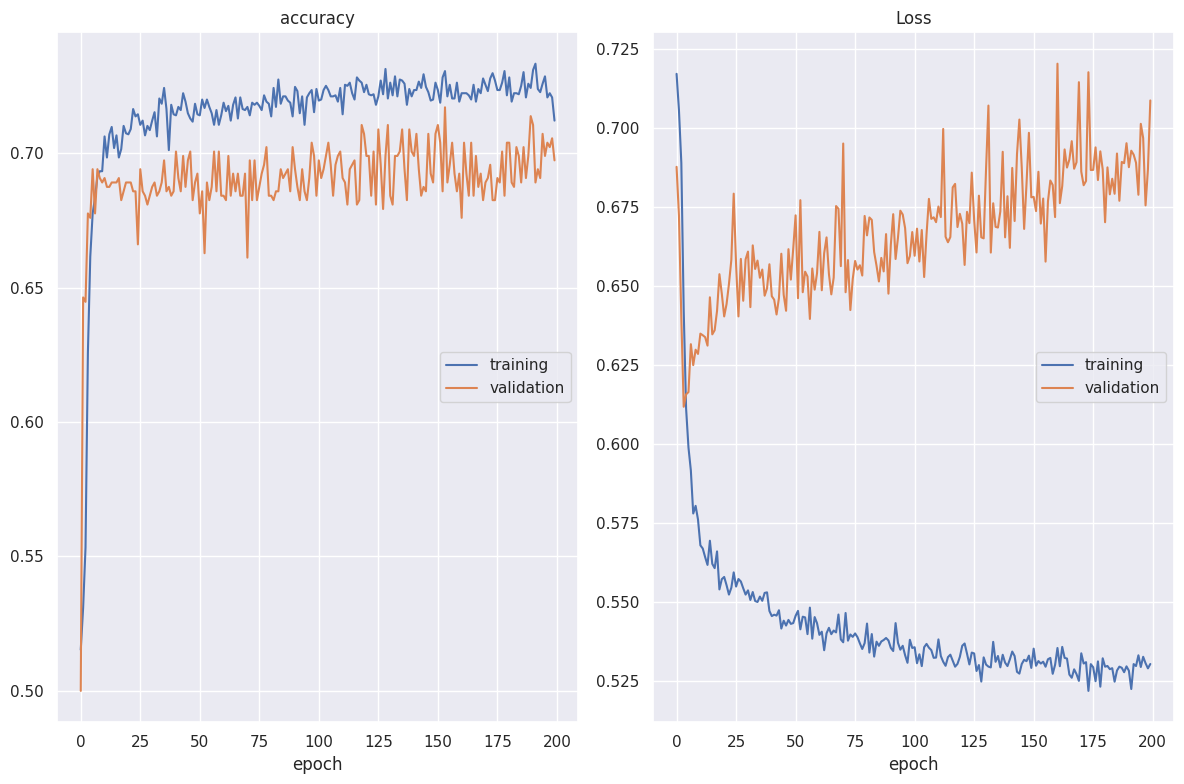

accuracy
	training         	 (min:    0.515, max:    0.733, cur:    0.712)
	validation       	 (min:    0.500, max:    0.717, cur:    0.697)
Loss
	training         	 (min:    0.522, max:    0.717, cur:    0.530)
	validation       	 (min:    0.612, max:    0.720, cur:    0.709)

Epoch 200: val_accuracy did not improve from 0.71711
51/51 [==============================] - 1s 15ms/step - loss: 0.5303 - accuracy: 0.7122 - val_loss: 0.7086 - val_accuracy: 0.6974


In [120]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_50_epochs_200_only_import_feat_norm'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=50, epochs=200)

#### Prediction and results

Accuracy: 0.7198697068403909
Precision: [0.72575251 0.71428571]
Recall: 0.7328990228013029
F1 score: 0.723473
ROC AUC: 0.719870


(0.7198697068403909,
 array([0.72575251, 0.71428571]),
 0.7328990228013029,
 0.7234726688102894,
 0.7198697068403908)

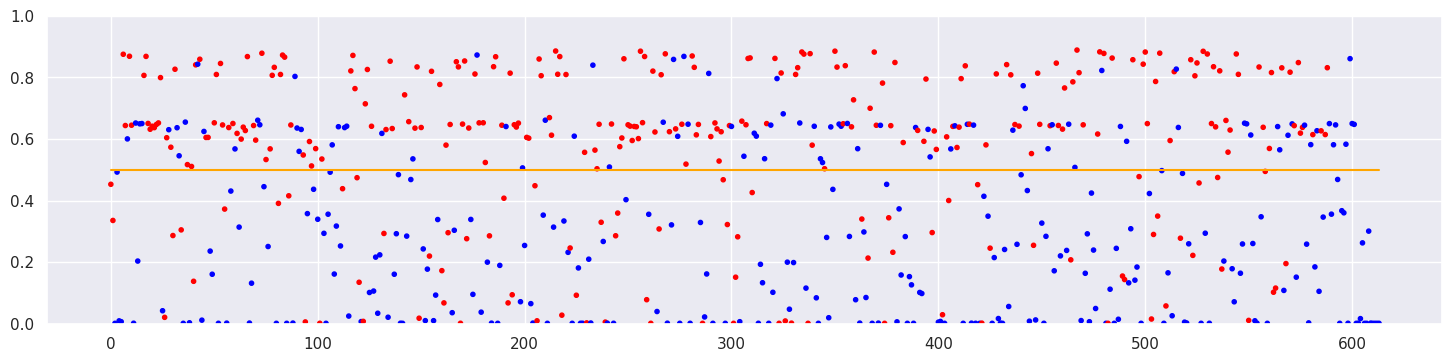

<Figure size 640x480 with 0 Axes>

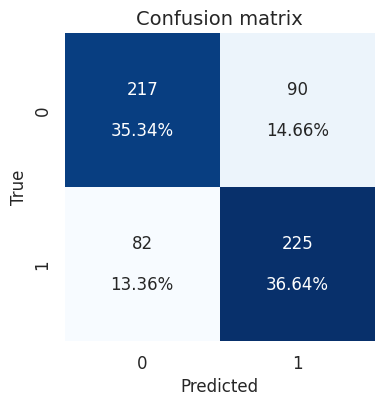

In [121]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=100, epochs=200

#### Create and train model

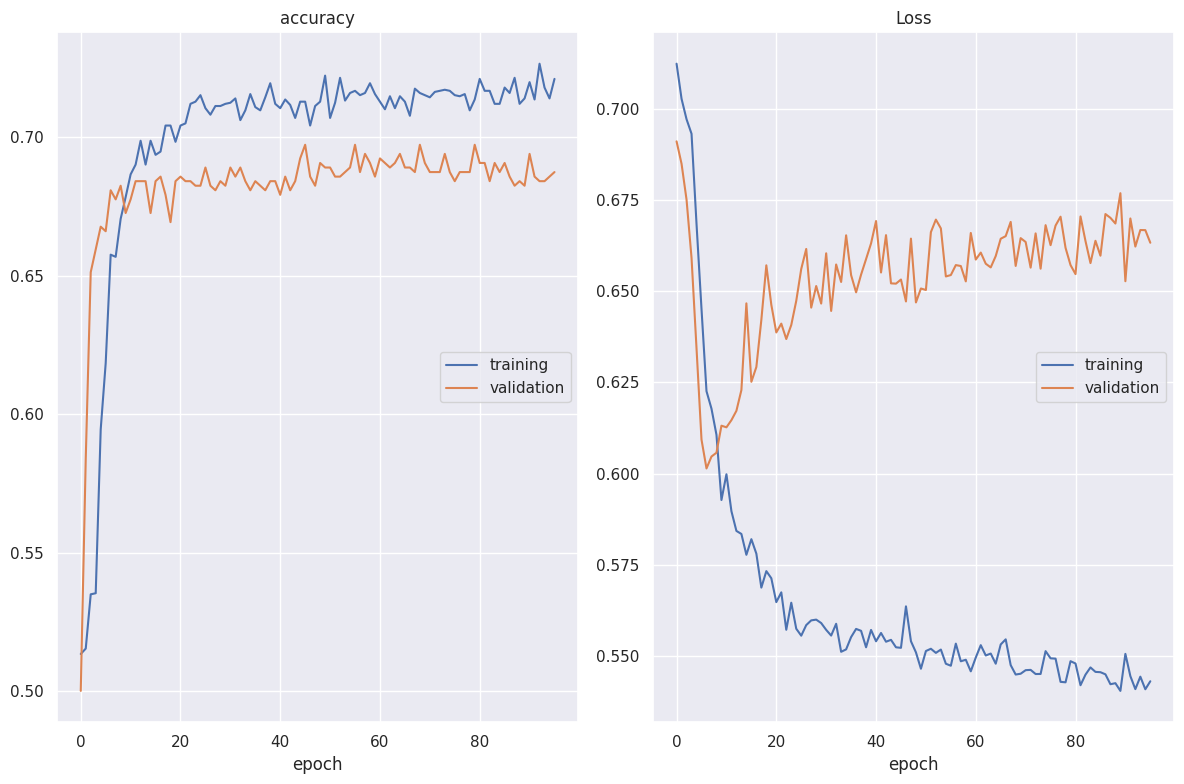

accuracy
	training         	 (min:    0.513, max:    0.727, cur:    0.721)
	validation       	 (min:    0.500, max:    0.697, cur:    0.688)
Loss
	training         	 (min:    0.541, max:    0.712, cur:    0.543)
	validation       	 (min:    0.601, max:    0.691, cur:    0.663)

Epoch 96: val_accuracy did not improve from 0.69737
26/26 [==============================] - 1s 26ms/step - loss: 0.5431 - accuracy: 0.7212 - val_loss: 0.6632 - val_accuracy: 0.6875


In [122]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_100_epochs_200_only_import_feat_norm'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=100, epochs=200)

#### Prediction and results

Accuracy: 0.7182410423452769
Precision: [0.7518797  0.69252874]
Recall: 0.7850162866449512
F1 score: 0.735878
ROC AUC: 0.718241


(0.7182410423452769,
 array([0.7518797 , 0.69252874]),
 0.7850162866449512,
 0.73587786259542,
 0.718241042345277)

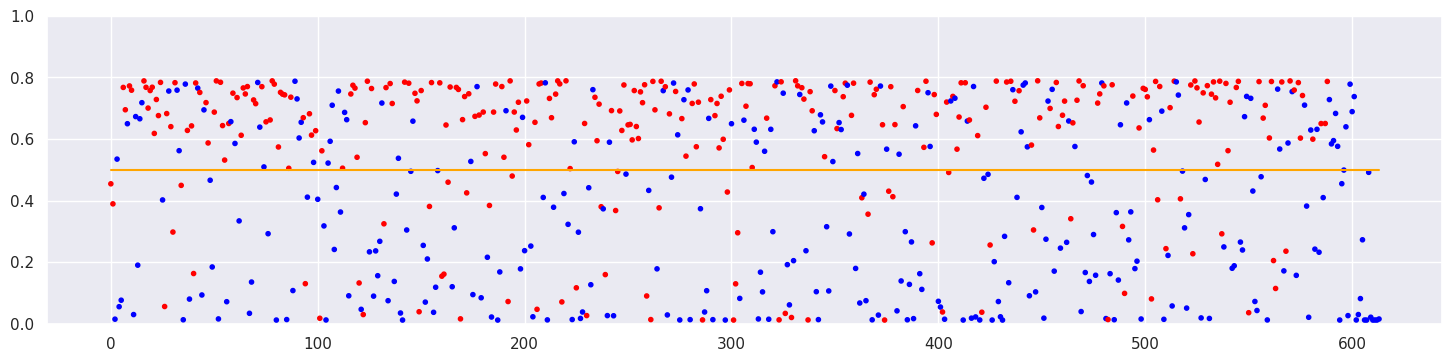

<Figure size 640x480 with 0 Axes>

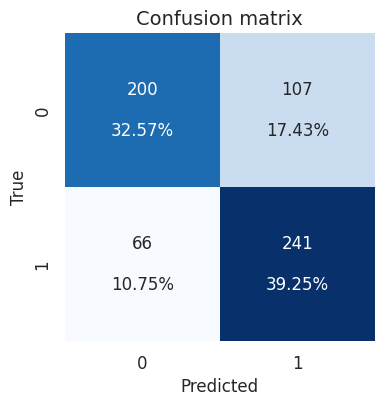

In [123]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=150, epochs=200

#### Create and train model

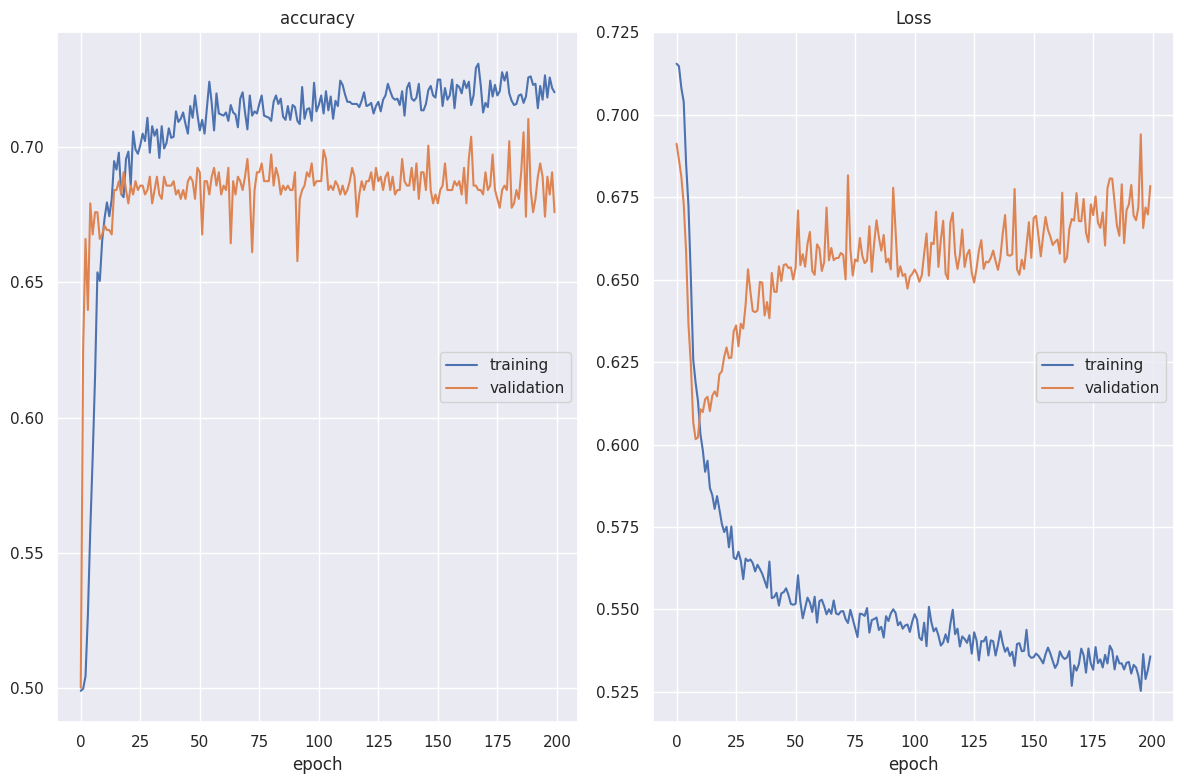

accuracy
	training         	 (min:    0.499, max:    0.731, cur:    0.720)
	validation       	 (min:    0.500, max:    0.711, cur:    0.676)
Loss
	training         	 (min:    0.525, max:    0.716, cur:    0.536)
	validation       	 (min:    0.602, max:    0.694, cur:    0.678)

Epoch 200: val_accuracy did not improve from 0.71053
17/17 [==============================] - 1s 43ms/step - loss: 0.5358 - accuracy: 0.7204 - val_loss: 0.6784 - val_accuracy: 0.6760


In [124]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_150_epochs_200_only_import_feat_norm'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=150, epochs=200)

#### Prediction and results

Accuracy: 0.7084690553745928
Precision: [0.68823529 0.73357664]
Recall: 0.6547231270358306
F1 score: 0.691910
ROC AUC: 0.708469


(0.7084690553745928,
 array([0.68823529, 0.73357664]),
 0.6547231270358306,
 0.6919104991394147,
 0.7084690553745928)

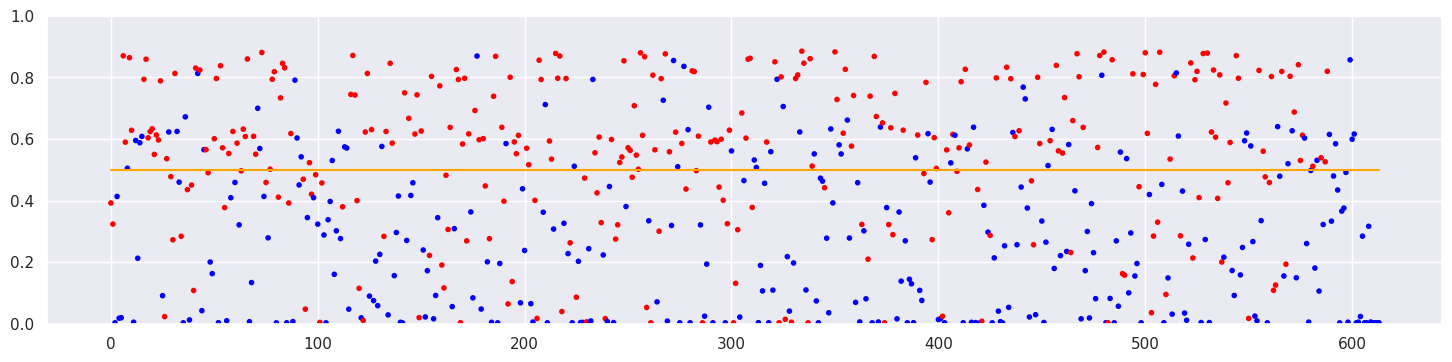

<Figure size 640x480 with 0 Axes>

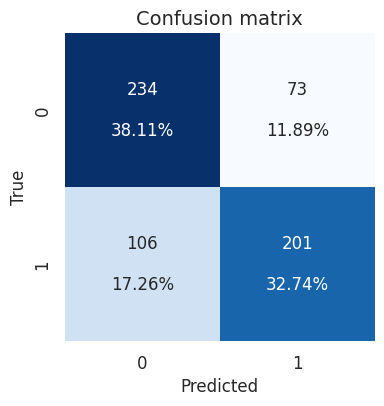

In [125]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=200, epochs=200

#### Create and train model

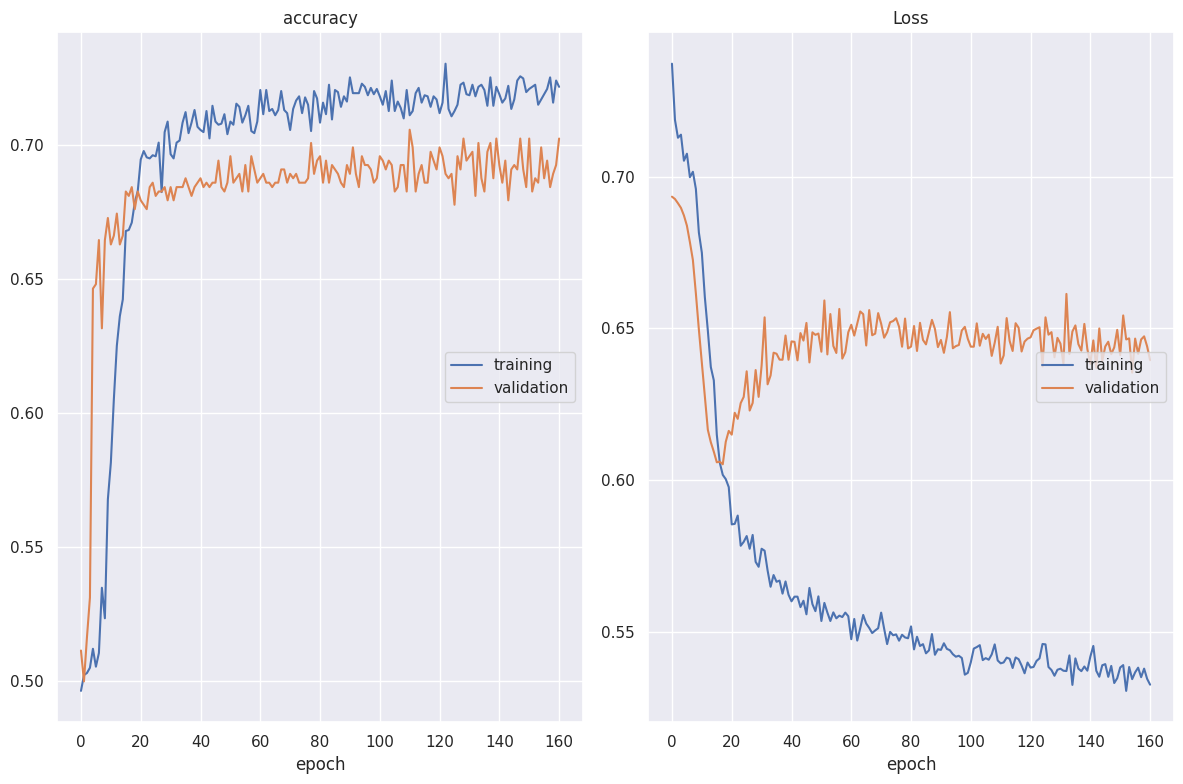

accuracy
	training         	 (min:    0.496, max:    0.730, cur:    0.722)
	validation       	 (min:    0.500, max:    0.706, cur:    0.702)
Loss
	training         	 (min:    0.531, max:    0.737, cur:    0.533)
	validation       	 (min:    0.605, max:    0.693, cur:    0.640)

Epoch 161: val_accuracy did not improve from 0.70559
13/13 [==============================] - 1s 55ms/step - loss: 0.5327 - accuracy: 0.7216 - val_loss: 0.6395 - val_accuracy: 0.7023


In [126]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_200_epochs_200_only_import_feat_norm'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=200, epochs=200)

#### Prediction and results

Accuracy: 0.7117263843648208
Precision: [0.73550725 0.69230769]
Recall: 0.762214983713355
F1 score: 0.725581
ROC AUC: 0.711726


(0.7117263843648208,
 array([0.73550725, 0.69230769]),
 0.762214983713355,
 0.7255813953488371,
 0.7117263843648208)

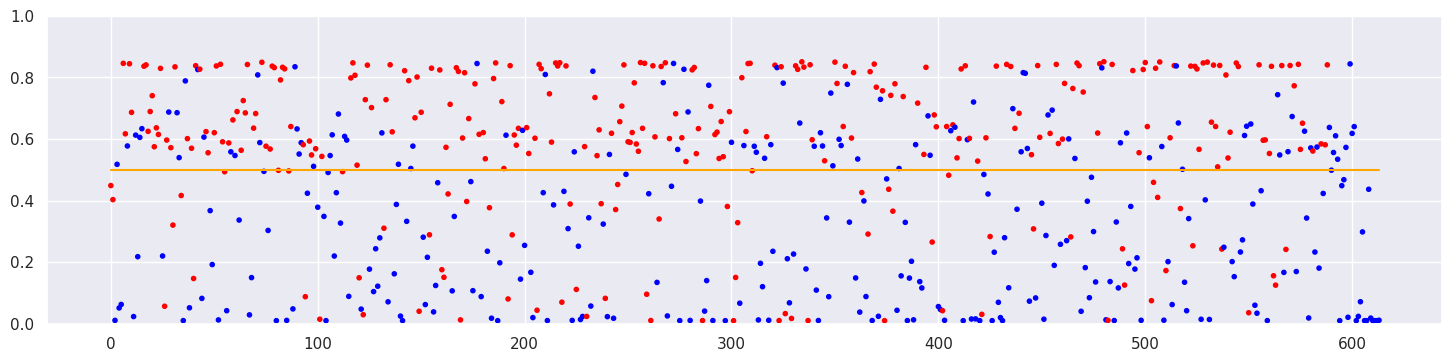

<Figure size 640x480 with 0 Axes>

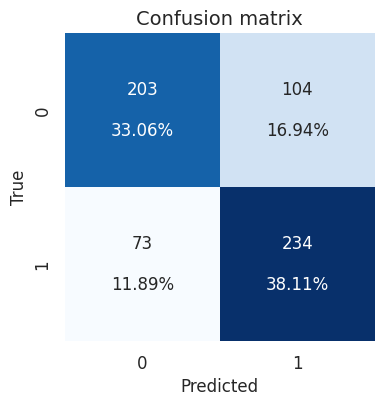

In [127]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=250, epochs=200

#### Create and train model

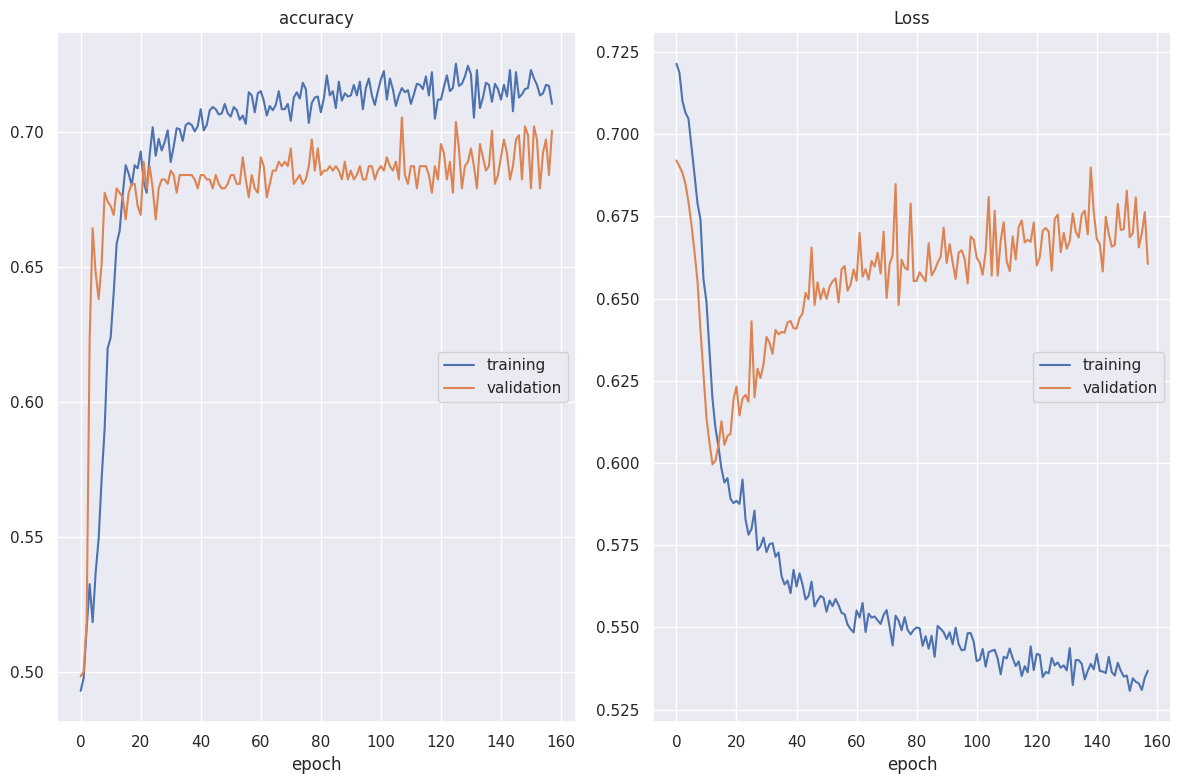

accuracy
	training         	 (min:    0.493, max:    0.725, cur:    0.711)
	validation       	 (min:    0.498, max:    0.706, cur:    0.701)
Loss
	training         	 (min:    0.531, max:    0.721, cur:    0.537)
	validation       	 (min:    0.600, max:    0.692, cur:    0.661)

Epoch 158: val_accuracy did not improve from 0.70559
11/11 [==============================] - 1s 68ms/step - loss: 0.5368 - accuracy: 0.7106 - val_loss: 0.6605 - val_accuracy: 0.7007


In [128]:
model_name = 'model_users_only_10000_1_v2_wo_outliers_batch_size_250_epochs_200_only_import_feat_norm'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=250, epochs=200)

#### Prediction and results

Accuracy: 0.7149837133550488
Precision: [0.73741007 0.69642857]
Recall: 0.762214983713355
F1 score: 0.727838
ROC AUC: 0.714984


(0.7149837133550488,
 array([0.73741007, 0.69642857]),
 0.762214983713355,
 0.7278382581648521,
 0.7149837133550488)

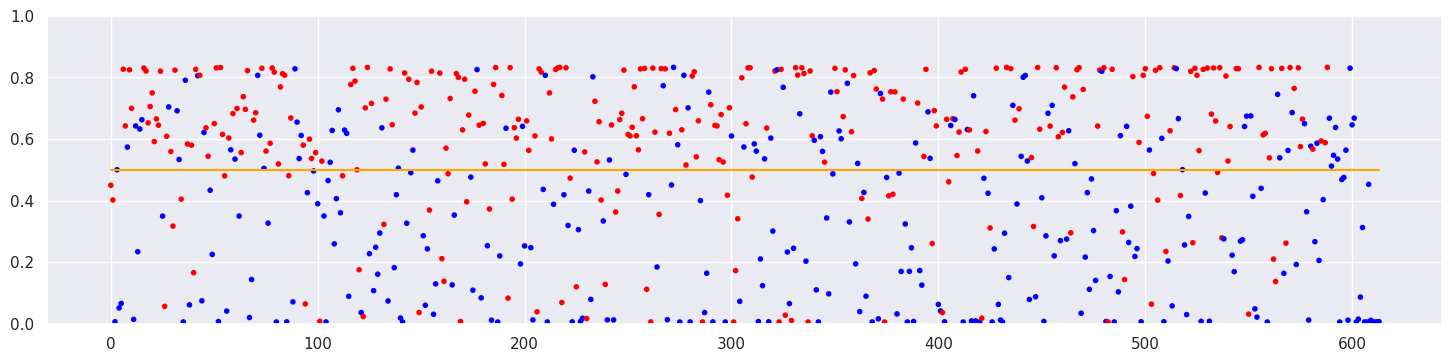

<Figure size 640x480 with 0 Axes>

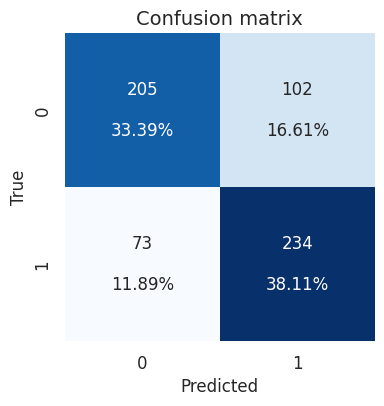

In [129]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)